1. Create Vectordb with unkown documents??
2. Create Vectordb with known documents
    1. Create metadata entries in the DB with their json outputs answers
3. Create query builder which takes in multiple known documents and a single unknown document

This script processes a PDF file containing regists (entries), extracts structured information, and uses semantic similarity with known documents to extract metadata. The pipeline involves text extraction, regex-based parsing, embedding generation, and vector database integration to facilitate querying and comparison. The output is exported in structured formats (CSV/JSON) for further use.

Processes and Features:
1. **PDF Processing**:
   - **Input Handling**: The script processes pages starting from page 101 of the PDF, where the regists begin. Each regist corresponds to a request sent to the papal office, usually containing details of the requester and the request itself.
   - **Text Structure**: 
     - Pages are in two-column layout. Continuity between columns is handled automatically by the library.
     - Bounding boxes, defined as the intersection of the media and crop boxes, remain static across pages.
   - **Output**: Extracted text is processed as a list of regists, each representing a single entry.

2. **Regex-Based Parsing**:
   - **Regist Identification**: The first regex process segments the extracted text into individual regists, ensuring that multi-page regists are handled correctly.
     - Exception Handling: Entry 2522 is treated separately as it does not conform to the expected pattern (begins with "N. N. in senili").
   - **Header and Sublemma Parsing**: 
     - The header contains details about the person making the request (e.g., name, title). A domain expert's input is needed to describe this structure in detail.
     - Sublemmas, which follow the colon in the header, contain the request details and are separated by hyphens.
   - **Date Extraction**: A second regex process splits sublemmas and extracts dates.
   - **Error Handling**: 
     - Parsing exceptions are logged and printed later for review.
     - Known exceptions are tracked explicitly and processed separately.

3. **Vector Database (Vectordb) Integration**:
   - **Known vs. Unknown Documents**:
     - Known documents are sourced from the WIAG and RG APIs and are associated with their respective metadata.
     - Unknown documents are extracted from the PDF and lack metadata.
     - Both types are stored in separate vector database collections.
   - **Embedding Generation**:
     - Sentence embeddings are generated using the `all-MiniLM-L6-v2` model provided by the chromadb library.
     - These embeddings are used for similarity search to identify matching regists.

4. **Query Building and LLM Integration**:
   - **Query Purpose**: Queries are formulated to pass an unknown document and retrieve metadata using the context provided by similar known documents.
   - **Prompt Engineering**:
     - The current approach uses static templates with minimal customization.
     - Known document examples are included as solved references to guide the LLM in parsing unknown documents.
     - Scope for improvement: Incorporating dynamic prompts and better system instructions.
   - **APIs Used**:
     - WIAG: Provides the desired format for regists.
     - RG: Contains regist details from the PDF.
     - SAIA: Enables ChatGPT-compatible API interaction for LLM processing (rate limits apply).

5. **Output Formats**:
   - **CSV Export**:
     - Includes IDs for regists (based on band and regist numbers).
     - Separately demarcates headers, sublemmas, and extracted dates.
   - **JSON Export**:
     - Not fully implemented for SAIA. Currently, the raw response is retained without transformation.

6. **Visualization**:
   - Length distributions and cumulative density functions (CDFs) are plotted to explore and analyze text features.
   - Useful for feature analysis and debugging.

7. **Error Handling**:
   - Known edge cases in text extraction are tracked explicitly (e.g., entry 2522).
   - Currently, there are no issues with the PDF itself. Future-proofing is recommended to handle unexpected edge cases.

8. **Scalability**:
   - The current pipeline is not optimized for large-scale datasets.
   - Suggestions for improvement:
     - Refactor the script into modular Python packages (e.g., separate regex extraction, database ingestion, and querying).
     - Enhance batching and parallelization, especially for API requests.

Dependencies:
- requests: For API integration.
- re: For regex-based text parsing.
- pandas: For structured data handling.
- json: For JSON parsing and export.
- tqdm: For progress visualization.
- pypdfium2: For PDF processing.
- csv: For structured data export.
- sklearn.metrics.pairwise: For similarity calculations.

Future Improvements:
- Add support for dynamic prompt engineering.
- Handle unstructured or edge-case text in regists.
- Optimize for large-scale processing by incorporating multiprocessing or cloud-based solutions.

Notes:
- Ensure API keys and endpoint URLs are updated as needed.
- Domain expert input is required to understand and annotate specific details in the header structure.

In [1]:
import requests

In [2]:
import re
import pandas as pd
import json
import traceback
from tqdm.notebook import tqdm

In [3]:
#!py -m pip install -U pypdfium2

In [4]:
#!py -m pip install -U scikit-learn

In [5]:
import pypdfium2 as pdfium

In [6]:
pdf = pdfium.PdfDocument('rgx_text_bd1_mn-2.pdf')
version = pdf.get_version()  # get the PDF standard version
n_pages = len(pdf)  # get the number of pages in the document
page = pdf[0]  # load a page

In [7]:
page

<PdfPage uuid:0bd7b90f>

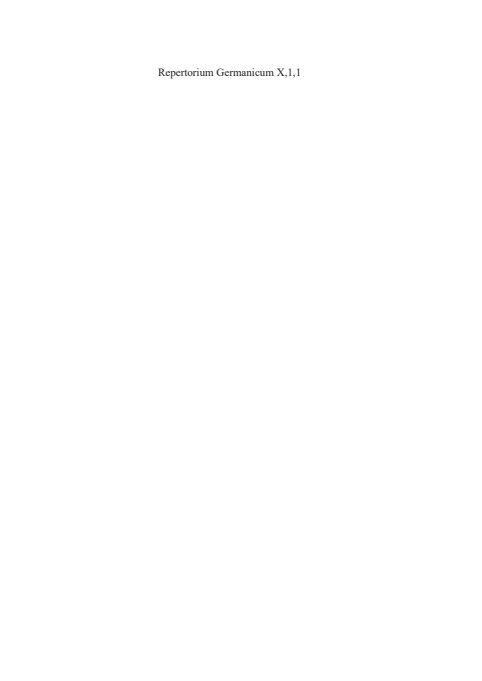

In [8]:
page.render(
    scale = 1,    # 72dpi resolution
    rotation = 0, # no additional rotation
    # ... further rendering options
).to_pil()

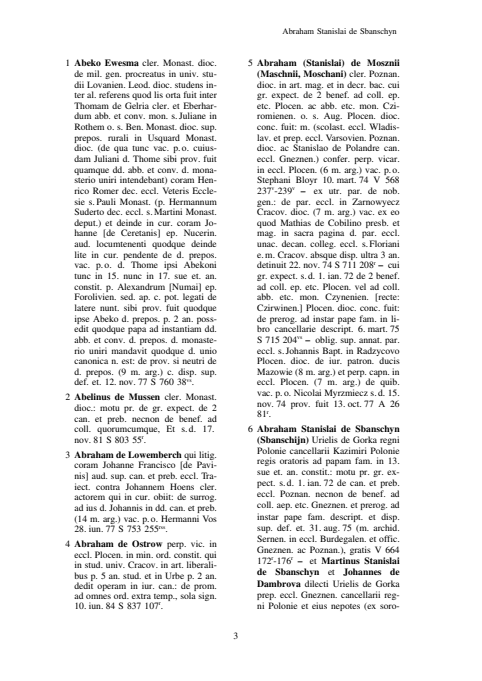

In [9]:
pdf[100].render(
    scale = 1,    # 72dpi resolution
    rotation = 0, # no additional rotation
    # ... further rendering options
).to_pil()

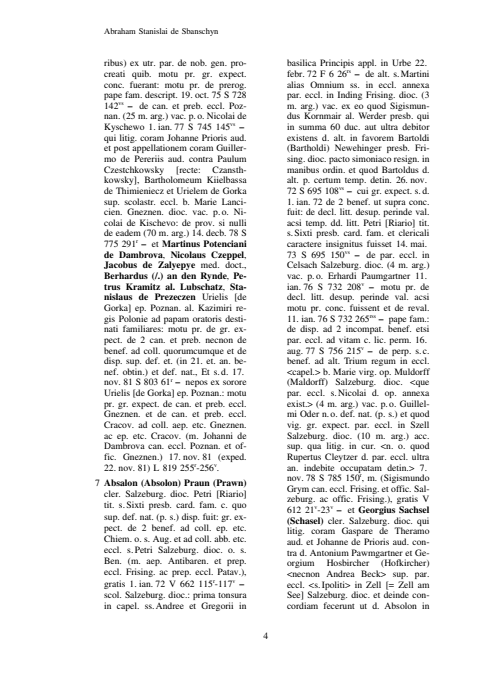

In [10]:
pdf[101].render(
    scale = 1,    # 72dpi resolution
    rotation = 0, # no additional rotation
    # ... further rendering options
).to_pil()

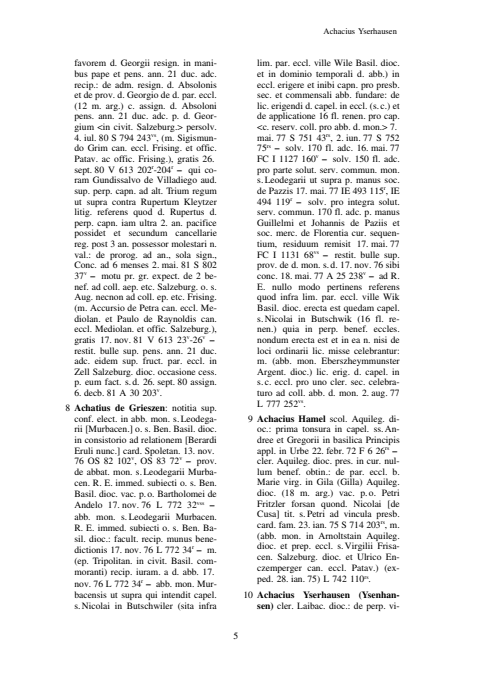

In [11]:
pdf[102].render(
    scale = 1,    # 72dpi resolution
    rotation = 0, # no additional rotation
    # ... further rendering options
).to_pil()

# Reading the data

In [12]:
textpage = pdf[100].get_textpage()

In [13]:
help(textpage.search)

Help on method search in module pypdfium2._helpers.textpage:

search(text, index=0, match_case=False, match_whole_word=False, consecutive=False) method of pypdfium2._helpers.textpage.PdfTextPage instance
    Locate text on the page.
    
    Parameters:
        text (str):
            The string to search for.
        index (int):
            Character index at which to start searching.
        match_case (bool):
            If True, the search will be case-specific (upper and lower letters treated as different characters).
        match_whole_word (bool):
            If True, substring occurrences will be ignored (e. g. `cat` would not match `category`).
        consecutive (bool):
            If False (the default), :meth:`.search` will skip past the current match to look for the next match.
            If True, parts of the previous match may be caught again (e. g. searching for `aa` in `aaaa` would match 3 rather than 2 times).
    Returns:
        PdfTextSearcher: A helper object 

In [14]:
pdf[100].get_size()

(481.93658447265625, 680.3626098632812)

In [15]:
left, bottom, right, top = pdf[100].get_bbox()
left, bottom, right, top

(20.97640037536621, 20.97640037536621, 502.9129943847656, 701.3389892578125)

In [16]:
pdf[101].get_bbox()

(20.97640037536621, 20.97640037536621, 502.9129943847656, 701.3389892578125)

In [17]:
textpage = pdf[100].get_textpage()
all_text = textpage.get_text_bounded(left=left, bottom=bottom, right=right, top=top)

print(len(all_text))
all_text

3763


'1 Abeko Ewesma cler. Monast. dioc.\r\nde mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter\r\nThomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in\r\nRothem o. s. Ben. Monast. dioc. sup.\r\nprepos. rurali in Usquard Monast.\r\ndioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit\r\nquamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum\r\nSuderto dec. eccl. s. Martini Monast.\r\ndeput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.\r\naud. locumtenenti quodque deinde\r\nlite in cur. pendente de d. prepos.\r\nvac. p. o. d. Thome ipsi Abekoni\r\ntunc in 15. nunc in 17. sue et. an.\r\nconstit. p. Alexandrum [Numai] ep.\r\nForolivien. sed. ap. c. pot. legati de\r\nlatere nunt. sibi prov. fuit quodque\r\nipse Abeko d. prepos. p. 2 an. poss\x02edit quodque papa ad inst

In [18]:
textpage = pdf[100].get_textpage()
white_padding = 40
all_text = textpage.get_text_bounded(left=left, bottom=bottom + white_padding + 10, right=right, top=top - white_padding)

print(len(all_text))
all_text

3728


'1 Abeko Ewesma cler. Monast. dioc.\r\nde mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter\r\nThomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in\r\nRothem o. s. Ben. Monast. dioc. sup.\r\nprepos. rurali in Usquard Monast.\r\ndioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit\r\nquamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum\r\nSuderto dec. eccl. s. Martini Monast.\r\ndeput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.\r\naud. locumtenenti quodque deinde\r\nlite in cur. pendente de d. prepos.\r\nvac. p. o. d. Thome ipsi Abekoni\r\ntunc in 15. nunc in 17. sue et. an.\r\nconstit. p. Alexandrum [Numai] ep.\r\nForolivien. sed. ap. c. pot. legati de\r\nlatere nunt. sibi prov. fuit quodque\r\nipse Abeko d. prepos. p. 2 an. poss\x02edit quodque papa ad inst

In [19]:
data = []
white_padding = 40
for i in range(100, len(pdf)):
    textpage = pdf[i].get_textpage()
    text_all = textpage.get_text_bounded(left=left, bottom=bottom + white_padding + 10, right=right, top=top - white_padding)
    data.append(text_all)

In [20]:
len(data)

712

In [21]:
data[0]

'1 Abeko Ewesma cler. Monast. dioc.\r\nde mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter\r\nThomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in\r\nRothem o. s. Ben. Monast. dioc. sup.\r\nprepos. rurali in Usquard Monast.\r\ndioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit\r\nquamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum\r\nSuderto dec. eccl. s. Martini Monast.\r\ndeput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.\r\naud. locumtenenti quodque deinde\r\nlite in cur. pendente de d. prepos.\r\nvac. p. o. d. Thome ipsi Abekoni\r\ntunc in 15. nunc in 17. sue et. an.\r\nconstit. p. Alexandrum [Numai] ep.\r\nForolivien. sed. ap. c. pot. legati de\r\nlatere nunt. sibi prov. fuit quodque\r\nipse Abeko d. prepos. p. 2 an. poss\x02edit quodque papa ad inst

In [22]:
data[0].split('\r\n')

['1 Abeko Ewesma cler. Monast. dioc.',
 'de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter',
 'Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in',
 'Rothem o. s. Ben. Monast. dioc. sup.',
 'prepos. rurali in Usquard Monast.',
 'dioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit',
 'quamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum',
 'Suderto dec. eccl. s. Martini Monast.',
 'deput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.',
 'aud. locumtenenti quodque deinde',
 'lite in cur. pendente de d. prepos.',
 'vac. p. o. d. Thome ipsi Abekoni',
 'tunc in 15. nunc in 17. sue et. an.',
 'constit. p. Alexandrum [Numai] ep.',
 'Forolivien. sed. ap. c. pot. legati de',
 'latere nunt. sibi prov. fuit quodque',
 'ipse Abeko d. prepos. p. 2 an. poss\x02edit quo

# regex attempt

In [23]:
data[0]

'1 Abeko Ewesma cler. Monast. dioc.\r\nde mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter\r\nThomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in\r\nRothem o. s. Ben. Monast. dioc. sup.\r\nprepos. rurali in Usquard Monast.\r\ndioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit\r\nquamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum\r\nSuderto dec. eccl. s. Martini Monast.\r\ndeput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.\r\naud. locumtenenti quodque deinde\r\nlite in cur. pendente de d. prepos.\r\nvac. p. o. d. Thome ipsi Abekoni\r\ntunc in 15. nunc in 17. sue et. an.\r\nconstit. p. Alexandrum [Numai] ep.\r\nForolivien. sed. ap. c. pot. legati de\r\nlatere nunt. sibi prov. fuit quodque\r\nipse Abeko d. prepos. p. 2 an. poss\x02edit quodque papa ad inst

In [24]:
data[1]

'ribus) ex utr. par. de nob. gen. pro\x02creati quib. motu pr. gr. expect.\r\nconc. fuerant: motu pr. de prerog.\r\npape fam. descript. 19. oct. 75 S 728\r\n142vs – de can. et preb. eccl. Poz\x02nan. (25 m. arg.) vac. p. o. Nicolai de\r\nKyschewo 1. ian. 77 S 745 145vs –\r\nqui litig. coram Johanne Prioris aud.\r\net post appellationem coram Guiller\x02mo de Pereriis aud. contra Paulum\r\nCzestchkowsky [recte: Czansth\x02kowsky], Bartholomeum Kiielbassa\r\nde Thimieniecz et Urielem de Gorka\r\nsup. scolastr. eccl. b. Marie Lanci\x02cien. Gneznen. dioc. vac. p. o. Ni\x02colai de Kischevo: de prov. si nulli\r\nde eadem (70 m. arg.) 14. decb. 78 S\r\n775 291r – et Martinus Potenciani\r\nde Dambrova, Nicolaus Czeppel,\r\nJacobus de Zalyepye med. doct.,\r\nBerhardus (/.) an den Rynde, Pe\x02trus Kramitz al. Lubschatz, Sta\x02nislaus de Prezeczen Urielis [de\r\nGorka] ep. Poznan. al. Kazimiri re\x02gis Polonie ad papam oratoris desti\x02nati familiares: motu pr. de gr. ex\x02pect. de 2 can. 

In [25]:
def parse_segment(array: list):
    return ''.join(current_segment).strip().replace('\x02', '').replace('\r\n', '\n')

In [26]:
# Initialize variables
name_regex = '[A-Z][a-z]+'
word_regex = '[A-Za-z]+'
word_dot_regex = f'{word_regex}\.?'
pattern = (
    f'^(?:\d+ {name_regex}|' # a digit followed by a correct grammatical word
    f'\d+ \[{word_dot_regex}(?: {word_dot_regex})*\] {word_regex}|' # a digit followed by an abbreviation
    f'\d+ \({name_regex}\) {word_regex})' # a digit followed by a name in parenthesis and then a word
)

skip_indices = {2522}

previous_number = None

current_segment = []
segment_text =''
output = []
for data_i, text in enumerate(data):
    print(f"new page with previous_number {previous_number}")
    # Split the text into lines for processing
    lines = text.splitlines(keepends=True)
    
    # Iterate through the lines to find segments
    for line in lines:
        # Check if the line starts with a number followed by a space
        if re.match(pattern, line):
            if current_segment:
                # Join and check the previous segment before starting a new one
                segment_text = parse_segment(current_segment)
                current_number = int(line.split()[0])

                
                if previous_number is None or current_number == previous_number + 1:
                    if current_number + 1 in skip_indices:
                        print(f"Skipping entry number {current_number + 1}")
                        current_number += 1
                    previous_number = current_number
                    
                else:
                    print(f"=============================Warning: Found a non-sequential number {current_number} after {previous_number}")
                    print(data_i, line)
                    current_segment.append(line)  # Append non-sequential line to current segment
                    continue
            
            # Reset current segment for the new entry
            print("current_segment", current_segment)
            output.append(segment_text)
            current_segment = [line]
        else:
            current_segment.append(line)
    
    # Don't forget to add the last segment if exists
    if current_segment:
        segment_text = parse_segment(current_segment)
        current_number = int(segment_text.split()[0])
        
        if previous_number is None or current_number == previous_number + 1:
            output.append(segment_text)
            print('#' * 10)
            print("segment_text", segment_text)
        else:
            # print(f"########## Warning: Found a non-sequential number {current_number} after {previous_number}")
            pass
    # entries.append(output)
    # Print the result
    # for item in output:
    #     print(item)
    #     print()
output.append(parse_segment(current_segment))

new page with previous_number None
current_segment []
current_segment ['1 Abeko Ewesma cler. Monast. dioc.\r\n', 'de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter\r\n', 'Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in\r\n', 'Rothem o. s. Ben. Monast. dioc. sup.\r\n', 'prepos. rurali in Usquard Monast.\r\n', 'dioc. (de qua tunc vac. p. o. cuius\x02dam Juliani d. Thome sibi prov. fuit\r\n', 'quamque dd. abb. et conv. d. mona\x02sterio uniri intendebant) coram Hen\x02rico Romer dec. eccl. Veteris Eccle\x02sie s. Pauli Monast. (p. Hermannum\r\n', 'Suderto dec. eccl. s. Martini Monast.\r\n', 'deput.) et deinde in cur. coram Jo\x02hanne [de Ceretanis] ep. Nucerin.\r\n', 'aud. locumtenenti quodque deinde\r\n', 'lite in cur. pendente de d. prepos.\r\n', 'vac. p. o. d. Thome ipsi Abekoni\r\n', 'tunc in 15. nunc in 17. sue et. an.\r\n', 'constit. p. Alexandrum [Numai] ep.\r\n', 'Forolivien. sed. ap

In [27]:
print(re.match(pattern, '60 Admont\r\n'))
print(re.match(pattern, '61 Adolphus de Bibera ex utr. par. de\r\n'))
print(re.match(pattern, '100 [Adolphus] test case here\r\n'))
print(re.match(pattern, '283 [mon.] Sancti Andree cis Traisi\x02nam\r\n'))
print(re.match(pattern, '936 [Bertoldus de Oberg] ep. Panaden.:\r\n'))
print(re.match(pattern, '2117 (Ewaldus) Cymmerman: pro for\x02mata [solv.] 6 grossos decb. 77 T 13\r\n'))
print(re.match(pattern, '2415 [mon. et op.] Sancti Galli [1. pars 3\r\n'))

<re.Match object; span=(0, 9), match='60 Admont'>
<re.Match object; span=(0, 11), match='61 Adolphus'>
<re.Match object; span=(0, 19), match='100 [Adolphus] test'>
<re.Match object; span=(0, 17), match='283 [mon.] Sancti'>
<re.Match object; span=(0, 27), match='936 [Bertoldus de Oberg] ep'>
<re.Match object; span=(0, 24), match='2117 (Ewaldus) Cymmerman'>
<re.Match object; span=(0, 25), match='2415 [mon. et op.] Sancti'>


In [28]:
output[-1]


'2925 Gerwinus Haner de Susaco cler.\nColon. dioc. in 22. et. an. constit.\nnullum benef. obtin.: de can. et maiori preb. eccl. s. Patrocli op. Susacien. Colon. dioc. (6 m. arg.) vac.\np. o. Johannis Milinckhuys pape fam.\net c. disp. sup. et. 8. mart. 77 S 748\n124vs.'

In [29]:
current_segment

['2925 Gerwinus Haner de Susaco cler.\r\n',
 'Colon. dioc. in 22. et. an. constit.\r\n',
 'nullum benef. obtin.: de can. et ma\x02iori preb. eccl. s. Patrocli op. Susa\x02cien. Colon. dioc. (6 m. arg.) vac.\r\n',
 'p. o. Johannis Milinckhuys pape fam.\r\n',
 'et c. disp. sup. et. 8. mart. 77 S 748\r\n',
 '124vs.']

In [30]:
# Initialize counters
rn_count = 0
n_count = 0
r_count = 0

# Count occurrences
for string in output:
    rn_count += string.count('\r\n')
    n_count += string.count('\n') - string.count('\r\n')  # Exclude \r\n cases
    r_count += string.count('\r') - string.count('\r\n')  # Exclude \r\n cases

rn_count, n_count, r_count


(0, 56104, 0)

In [31]:
print(len(output))

2925


In [32]:
output[60:80]

['60 Admont\nAbb. et conv. mon. s. Blasii in Admont o. s. Ben. Salzeburg. dioc. referentes quod Ernestus Praucker laic.\nnonnullas decimas et bona ad d.\nmon. spectantes usurpat: de committ.\nin cur., Conc. in partibus 10. mart.\n75 S 715 195v\n.',
 '61 Adolphus de Bibera ex utr. par. de\nnob. seu mil. gen. dec. eccl. s. Burkardi e. m. Herbip.: de disp. ut unac.\nd. decan. (10 m. arg.) aliud incompat. benef. recip. val. etsi 2 par. eccl.\n31. decb. 77 S 762 263vs.',
 '62 Adolffus de Buetbach (Breytbach)\nprecept. dom. s. Johannis ord. s. Johannis Jerusalemitani Trever.: de incorp. d. preceptorie (20 m. arg.) par.\neccl. b. Marie ad pontem prope et\ne. m. Trever. d. precept. contiguam\n(4 m. arg.) 11. nov. 71 S 673 107vs –\ncommiss. Trever. [dioc.?] 80/81 I\n334 225r\n.',
 '63 Adolphus secundogenitus ducis\nCliven. et com. de Marchia cler.\nColon. dioc. in 16. sue et. an. constit.: supplic. d. duce de prepos. eccl.\ns. Martini Embricen. Traiect. dioc.\n(que in archidiac. eccl. Traiect. 

In [33]:
# # pattern = f'((?:[^\[\]]|\[[^\]]*\])*):(.*)'
# # pattern = f'((?:[^:]|\[.*:.*\])*):(.*)'
# # pattern = f'(.*):(?!\])(.*)'
# pattern = r'^((?:[^:\[\]]+|\[[^\]]*\])+)[:](.*)'
# print(pattern)

# counter = 0
# split_exceptions = []
# known_exceptions = {}

# headers = []
# sublemmas_list = []

# for i, regist in tqdm(enumerate(output)):
#     print(i)
#     found = re.findall(pattern, regist, re.DOTALL)
#     if found:
#         header, sublemmas = found[0]
#         counter += 1
#         headers.append(header)
#         sublemmas_list.append(sublemmas)
#     else:
#         print(f"Header and sublemmas not found in {i}")
#         headers.append(regist)
#         sublemmas_list.append('')
#         split_exceptions.append(i)
# print(len(split_exceptions), "/", len(output) - len(known_exceptions), "missing")
# print(split_exceptions)

# # for i, regist in tqdm(enumerate(output)):
# #     partitions = regist.split(":")
# #     if len(partitions) > 2:
# #         print('\n\n'.join(partitions))
# #         break

In [34]:
# pattern = f'((?:[^\[\]]|\[[^\]]*\])*):(.*)'
# pattern = f'((?:[^:]|\[.*:.*\])*):(.*)'
# pattern = f'(.*):(?!\])(.*)'
pattern = r'^((?:[^:\[\]]+|\[[^\]]*\])+)[:](.*)'
print(pattern)

counter = 0
split_exceptions = []
known_exceptions = {}

headers = []
sublemmas_list = []

def split_outside_brackets(s):
    in_brackets = 0
    for idx, char in enumerate(s):
        if char == '[':
            in_brackets += 1
        elif char == ']':
            if in_brackets > 0:
                in_brackets -= 1
        elif char == ':' and in_brackets == 0:
            # Split the string at this colon
            return s[:idx], s[idx+1:]
    # If no colon is found outside brackets, return the whole string and an empty string
    return s, ''

for i, regist in tqdm(enumerate(output)):
    header, sublemmas = split_outside_brackets(regist)
    headers.append(header)
    sublemmas_list.append(sublemmas)
    if sublemmas == '':
        split_exceptions.append(i)
print(len(split_exceptions), "/", len(output) - len(known_exceptions), "missing")
print(split_exceptions)

# for i, regist in tqdm(enumerate(output)):
#     partitions = regist.split(":")
#     if len(partitions) > 2:
#         print('\n\n'.join(partitions))
#         break

^((?:[^:\[\]]+|\[[^\]]*\])+)[:](.*)


0it [00:00, ?it/s]

4 / 2925 missing
[0, 332, 837, 2178]


In [35]:
output[961]

'961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte: Besekhem?] Spiren. dioc.: lic. erig. dom. pro usu fr. ord.\nhosp. s. Johannis Jerusalemitani\n72/73 I 332 254v\n.'

In [36]:
pattern = f'(.*):(?!.*?\])(.*)'
re.findall(pattern, output[361], re.DOTALL)

[('361 Andreas de Lapide (am Stein,\nAnystany) archid. Stirie et Marchie\nInferioris Salzeburg. dioc. Friderici\nR. I. secr. inter al. referens quod Antonius de Eugubio procur. fisci cam.\nap. falso asseruit quod quidam Michael Richardi al. Eucharii cler. Herbip. dioc. pape fam. litig. nomine\nPetri Kornmesser de Bruck supra\nMuram Salzeburg. dioc. coram iudicibus delegatis eccl. Salzeburg. (licet\nabbatibus de Novomonte et s. Trinitatis Nove Civitatis et archidiacono\nStirie et Marchie Superioris) contra\nd. Andream et Johannem Oberegker\ncommissarium archid. Stirie et Marchie sup. quibusdam pec. summis (in\nquib. d. Petro obligati erant) et quod\nquidam Paulus Gabelczhefer iudex\nop. Leuben Salzeburg. dioc. quendam Johannem de Moravia presb.\nOlomuc. dioc. (qui pro d. Michaele\ncontra dd. Andream et Johannem litig. intendit) capi et carceribus mancipari et torqueri fecit et quod quidam Pancratius not. certam citationem contra dd. Andream et Johannem et quendam Judocum de Scraz\nad va

In [37]:
pattern = f'(.*?):(.*)'
print(re.findall(pattern, output[522], re.DOTALL))
print(re.findall(pattern, output[961], re.DOTALL))

[('522 Antonius [Wis] (Voysse) abb. mon.\ns. Martini e. m. Meten.', ' solv. 70 fl.\nadc. p. manus Hugonis Porenliet pro\ncompositione annat. prioratus s. Georgii prope Peddesrszhem o. s. Ben.\nWormat. dioc. ratione commende de\nd. prioratu sibi facte 23. aug. 71 FC I\n1129 15v\n, 27. aug. 71 IE 487 1v –\nprep. mon. s. Georgii e. m. op. Pederszhem ut supra: narratio quod Petrus Kempchin cler. Wormat. dioc.\npape fam. de capn. ad alt. s. Johannis\nin d. mon. prov. fuit et Johannes\nMorman eum possessione indebitespoliavit, hortatio ut d. Petrum ad\npristinam possessionem restituat 18.\nmai. 77 Acquisti 27/1 183vs.')]
[('961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte', ' Besekhem?] Spiren. dioc.: lic. erig. dom. pro usu fr. ord.\nhosp. s. Johannis Jerusalemitani\n72/73 I 332 254v\n.')]


In [38]:
pattern = f'(.*):(.*)'
print(re.findall(pattern, output[522], re.DOTALL))
print(re.findall(pattern, output[961], re.DOTALL))

[('522 Antonius [Wis] (Voysse) abb. mon.\ns. Martini e. m. Meten.: solv. 70 fl.\nadc. p. manus Hugonis Porenliet pro\ncompositione annat. prioratus s. Georgii prope Peddesrszhem o. s. Ben.\nWormat. dioc. ratione commende de\nd. prioratu sibi facte 23. aug. 71 FC I\n1129 15v\n, 27. aug. 71 IE 487 1v –\nprep. mon. s. Georgii e. m. op. Pederszhem ut supra', ' narratio quod Petrus Kempchin cler. Wormat. dioc.\npape fam. de capn. ad alt. s. Johannis\nin d. mon. prov. fuit et Johannes\nMorman eum possessione indebitespoliavit, hortatio ut d. Petrum ad\npristinam possessionem restituat 18.\nmai. 77 Acquisti 27/1 183vs.')]
[('961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte: Besekhem?] Spiren. dioc.', ' lic. erig. dom. pro usu fr. ord.\nhosp. s. Johannis Jerusalemitani\n72/73 I 332 254v\n.')]


In [39]:
pattern = r'^((?:[^:\[\]]+|\[[^\]]*\])+)[:](.*)'
print(re.findall(pattern, output[522], re.DOTALL))
print(re.findall(pattern, output[961], re.DOTALL))

[('522 Antonius [Wis] (Voysse) abb. mon.\ns. Martini e. m. Meten.', ' solv. 70 fl.\nadc. p. manus Hugonis Porenliet pro\ncompositione annat. prioratus s. Georgii prope Peddesrszhem o. s. Ben.\nWormat. dioc. ratione commende de\nd. prioratu sibi facte 23. aug. 71 FC I\n1129 15v\n, 27. aug. 71 IE 487 1v –\nprep. mon. s. Georgii e. m. op. Pederszhem ut supra: narratio quod Petrus Kempchin cler. Wormat. dioc.\npape fam. de capn. ad alt. s. Johannis\nin d. mon. prov. fuit et Johannes\nMorman eum possessione indebitespoliavit, hortatio ut d. Petrum ad\npristinam possessionem restituat 18.\nmai. 77 Acquisti 27/1 183vs.')]
[('961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte: Besekhem?] Spiren. dioc.', ' lic. erig. dom. pro usu fr. ord.\nhosp. s. Johannis Jerusalemitani\n72/73 I 332 254v\n.')]


In [40]:
output[961]
# output[961]

'961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte: Besekhem?] Spiren. dioc.: lic. erig. dom. pro usu fr. ord.\nhosp. s. Johannis Jerusalemitani\n72/73 I 332 254v\n.'

In [41]:
re.findall(pattern, '[recte: Besekhem?]', re.DOTALL)

[]

In [42]:
headers[103:110]

['103 Aybing\nIncole et habitatores ville Aybing infra lim. par. eccl. Rateldorff Herbip.\ndioc. qui unam capel. antiquam sub\ninvocatione s. Jacobi (a d. par. eccl.\np. unum miliare distante) propter d.\ndistantiam in perp. s. c. benef. primissariam nunc. erigere et pro uno\npresb. inibi bis in hebdomada missas\ncelebrando pro illius dote 30 fl. renen. assign. desiderant',
 '104 Aymo de Divonna can. eccl. Gebennen. de nob. gen.',
 '105 Alamania (Almania, Alemania)\nMag. et fr. hosp. ord. b. Marie virg.\nTheotonicorum Jerosolimitan. p.\nAlemaniam et Italiam constit. referentes quod indulta privil. conservatoria etc. p. pontifices et reges ac imper. d. ord. conc. propter distantiam\ndomorum locorum et bonorum eorum et pericula lesionis scripture et\nsigillorum minime deferre possunt',
 '106 Alamania Superior\nConfederati Alte Lige Superioris\nAlamanie',
 '107 Alardus (Allardus) de Buren de\n<nob.> illustri gen. qui par. eccl. in\nReckem (Kerkem) Leod. dioc. (18\nm. arg.) ex causa perm. 

In [43]:
headers[955:965]

['955 Bertramus de Nesselraid (Nesselinde) mil. imper. qui eccl. b. Marie\nvirg. et s. Georgii in Eresteyn Colon.\ndioc. bonis dotavit',
 '956 Bertramus Wolder cler. Magunt.\ndioc. cui de perp. vicar. ad alt. b.\nMarie in eccl. s. Alexandri op. Eymbicen. Magunt. dioc. vac. p. o. Henrici Horn (quond. Prosperi [de Columna] tit. s. Georgii ad velum aureum diac. card. fam.) p. Johannem\nRekop prep. d. eccl. prov. fuit et qui\ndeinde litig. desup. coram Matheo de\nPorta aud. contra Conradum de Seldis actorem',
 '957 Bertrandus Hermanni (de Marvilla) presb. Trever. dioc.',
 '958 Bertrandus du Mortier Philiberti\n[Hugonet] tit. s. Lucie in Silice\npresb. card. fam.',
 '959 Bertrandus Wolici cler. Trever. dioc.',
 '960 Bessarion [Trapezunt.] card. [ep.\nTusculan.] Nicenus nunc.',
 '961 Besemlreim\nHabitatores et oppidani op. Besemlreim [recte: Besekhem?] Spiren. dioc.',
 '962 Bibrach\nMagistricivium et consules op. Bibrach Constant. dioc. referentes\nquod Cristmannus Lusser cler. Trever. dioc.

In [44]:
sublemmas_list[20:30]

[' de nova prov. de d. par. eccl.\n(16 m. arg.) 15. nov. 81 S 805 48r –\nde disp. ut benef. p. clericos sec. gubernari solitum obtin. val. necnon ut\nal. benef. curato deservire val. 11.\niun. 82 S 811 176v\n, L 823 300vs.',
 ' de prom. ad\nomnes ord. extra temp., sola sign. 6.\noct. 79 S 786 219r\n.',
 '\nde nova prov. de eadem (4 m. arg.)\net de n. prom. ad 5 an. et de abol.\ninhab. et infamie maculam 2. sept.\n83 S 828 112v\n.',
 ' m. (prep. eccl. ss. Martini et Arbogasti Surburgen. Argent. dioc.) assign. d. Ade pens. ann. 30 fl. auri\nrenen. sup. fruct. d. vicar. et prov.\nJohanni Heyl de Cappel Superiori\npresb. Argent. dioc. de d. vicar. (90\nfl. auri renen.) vacat. p. resign. d.\nAde in manibus d. prep. 18. apr. 82\n(exped. 22. apr. 82) L 814 205r\n-\n206v\n.',
 '\nde indulto ut absque lic. commendatoris d. ord. apud d. par. eccl. vel\naliud benef. personaliter residere\npossit c. derog. reg. stabilitatis 26.\napr. 79 S 780 274vs – fr.hosp. b.\nMarie Theotonicorum Jerosolimitan.

In [45]:
month = '(?:' + '\.|'.join([
    "ian", "febr", "mart", "apr", "mai", "iun", "iul", "aug", "sept", "oct", "nov", "decb"
]) + '\.)'

word_regex = '[A-Za-z]+'
word_dot_regex = f'{word_regex}\.?'
optional_bracket = f'(?:\({word_dot_regex}(?:\s{word_dot_regex})*\)\s)?'

ending_sequence = f'{optional_bracket}(?:\w|(?:\w+\.?,?\s)+\w+\.?)\s\d+.*?(?:–|.\s?$)'
date_pattern = f'(?:\d{{1,2}}(?:\.|\sgrossos)\s{month}\s\d{{2,4}}(?:\s\[\d\d\d\d\])?|\d\d/\d\d)'

date_missing = "[dat. deest]"

optional_secondary_date_pattern = f'(?:\s\(exped\.\s{date_pattern}\))?'

dioc_string = '(?:dioc|commiss)\.\??'
dioc_pattern = f'(?:\[{dioc_string}\]|{dioc_string})\s(?:vac.\sp.\so.\s)?(\d\d/\d\d)\s({ending_sequence})'

pattern = f'({date_pattern}){optional_secondary_date_pattern}\s({ending_sequence})'
print(pattern)

counter = 0
exceptions = []
known_exceptions = set(split_exceptions) - {0} | {352, 506, 583, 714, 732, 937, 945}

for i, regist in tqdm(enumerate(sublemmas_list)):
    dates = re.findall(pattern, regist, re.DOTALL)
    if dates:
        counter += 1
        print(f"Dates found in {i}: {dates}")
    elif dioc_dates := re.findall(dioc_pattern, regist, re.DOTALL):
        print(f"dioc found at {i}: {dioc_dates}")
    elif i not in known_exceptions:
        exceptions.append(i)
print(len(exceptions), "/", len(sublemmas_list) - len(known_exceptions), "missing")
print(exceptions)


((?:\d{1,2}(?:\.|\sgrossos)\s(?:ian\.|febr\.|mart\.|apr\.|mai\.|iun\.|iul\.|aug\.|sept\.|oct\.|nov\.|decb\.)\s\d{2,4}(?:\s\[\d\d\d\d\])?|\d\d/\d\d))(?:\s\(exped\.\s(?:\d{1,2}(?:\.|\sgrossos)\s(?:ian\.|febr\.|mart\.|apr\.|mai\.|iun\.|iul\.|aug\.|sept\.|oct\.|nov\.|decb\.)\s\d{2,4}(?:\s\[\d\d\d\d\])?|\d\d/\d\d)\))?\s((?:\([A-Za-z]+\.?(?:\s[A-Za-z]+\.?)*\)\s)?(?:\w|(?:\w+\.?,?\s)+\w+\.?)\s\d+.*?(?:–|.\s?$))


0it [00:00, ?it/s]

Dates found in 1: [('12. nov. 77', 'S 760 38vs.')]
Dates found in 2: [('17.\nnov. 81', 'S 803 55r\n.')]
Dates found in 3: [('28. iun. 77', 'S 753 255rss.')]
Dates found in 4: [('10. iun. 84', 'S 837 107r\n.')]
Dates found in 5: [('10. mart. 74', 'V 568\n237v\n-239v –'), ('22. nov. 74', 'S 711 208r –'), ('6. mart. 75', 'S 715 204vs –'), ('15.\nnov. 74', 'prov. fuit 13. oct. 77 A 26\n81r\n.')]
Dates found in 6: [('1. ian. 72', 'de can. et preb.\neccl. Poznan. necnon de benef. ad\ncoll. aep. etc. Gneznen. et prerog. ad\ninstar pape fam. descript. et disp.\nsup. def. et. 31. aug. 75 (m. archid.\nSernen. in eccl. Burdegalen. et offic.\nGneznen. ac Poznan.), gratis V 664\n172r\n-176r –'), ('19. oct. 75', 'S 728\n142vs –'), ('1. ian. 77', 'S 745 145vs –'), ('14. decb. 78', 'S\n775 291r –'), ('17.\nnov. 81', 'S 803 61r –'), ('17. nov. 81', 'L 819 255r\n-256v.')]
Dates found in 7: [('1. ian. 72', 'V 662 115r\n-117v –'), ('22.\nfebr. 72', 'F 6 26rs –'), ('26. nov.\n72', 'S 695 108vs –'), ('14. m

In [46]:

month = '(?:' + '\.|'.join([
    "ian", "febr", "mart", "apr", "mai", "iun", "iul", "aug", "sept", "oct", "nov", "decb"
]) + '\.)'

word_regex = '[A-Za-z]+'
word_dot_regex = f'{word_regex}\.?'
optional_bracket = f'(?:\({word_dot_regex}(?:\s{word_dot_regex})*\)\s)?'

ending_sequence = f'{optional_bracket}(?:\w|(?:\w+\.?,?\s)+\w+\.?)\s\d+.*?(?:–|.\s?$)'
date_pattern = f'(?:\d{{1,2}}(?:\.|\sgrossos)\s{month}\s\d{{2,4}}(?:\s\[\d\d\d\d\])?|\d\d/\d\d|\[sine\sdat\.\]|\[dat\.\sdeest\])'
optional_secondary_date_pattern = f'(?:\s\(exped\.\s{date_pattern}\))?'

date_missing = "\[dat. deest\]|\[sine dat.\]"

dioc_string = '(?:dioc|commiss)\.\??'
dioc_pattern = f'(?:\[{dioc_string}\]|{dioc_string})\s(?:vac.\sp.\so.\s)?(\d\d/\d\d)\s({ending_sequence})'

pattern = f'({date_pattern}){optional_secondary_date_pattern}\s({ending_sequence})'
print(pattern)

counter = 0
exceptions = []
known_exceptions = set(split_exceptions) - {0} | {352, 506, 583, 714, 732, 937, 945}

final_list = []

def split_by_ending_sequence(regist, pattern):
    splits = []
    last_end = 0  # Keep track of the last end position
    matches_found = False  # Flag to check if any matches are found

    # Find all matches of the main pattern
    for match in re.finditer(pattern, regist, re.DOTALL):
        matches_found = True
        date = match.group(1)
        ending_seq = match.group(2)
        start, end = match.span()

        # Text before the match
        # text_before = regist[last_end:start].strip()
        text_before = regist[last_end:end].strip()
        if text_before:
            splits.append({'text': text_before, 'date': date})

        # # Text of the match
        # matched_text = regist[start:end].strip()
        # splits.append({'date': date, 'ending_sequence': ending_seq.strip()})

        last_end = end  # Update the last end position

    # Text after the last match
    text_after = regist[last_end:].strip()
    if text_after:
        splits.append({'text': text_after})

    return splits, matches_found

# Process each sublemma while keeping exception handling logic
for i, (header, sublemmas) in enumerate(zip(headers, sublemmas_list)):
    if sublemmas == '' and i != 0:
        # print("Empty found!")
        # print("header", header)
        # print("sublemmas", sublemmas)
        # break
        print("No sublemma found")
        final_list.append({"header": header, "sublemmas": [{'text': f"{i} ", 'date': ""}]})
        print(final_list[-1])
        continue
    splits, matches_found = split_by_ending_sequence(sublemmas, pattern)
    if matches_found:
        print(f"Splits found in {i}:")
        for split in splits:
            print(split)
        final_list.append({"header": header, "sublemmas": splits})
    elif i not in known_exceptions:
        exceptions.append(i)
    else:
        print(f"No matches in {i}, but it's a known exception.")

print(len(exceptions), "/", len(sublemmas_list) - len(known_exceptions), "missing")
print("Exceptions:", known_exceptions, exceptions)

((?:\d{1,2}(?:\.|\sgrossos)\s(?:ian\.|febr\.|mart\.|apr\.|mai\.|iun\.|iul\.|aug\.|sept\.|oct\.|nov\.|decb\.)\s\d{2,4}(?:\s\[\d\d\d\d\])?|\d\d/\d\d|\[sine\sdat\.\]|\[dat\.\sdeest\]))(?:\s\(exped\.\s(?:\d{1,2}(?:\.|\sgrossos)\s(?:ian\.|febr\.|mart\.|apr\.|mai\.|iun\.|iul\.|aug\.|sept\.|oct\.|nov\.|decb\.)\s\d{2,4}(?:\s\[\d\d\d\d\])?|\d\d/\d\d|\[sine\sdat\.\]|\[dat\.\sdeest\])\))?\s((?:\([A-Za-z]+\.?(?:\s[A-Za-z]+\.?)*\)\s)?(?:\w|(?:\w+\.?,?\s)+\w+\.?)\s\d+.*?(?:–|.\s?$))
Splits found in 1:
{'text': 'de prov. si neutri de\nd. prepos. (9 m. arg.) c. disp. sup.\ndef. et. 12. nov. 77 S 760 38vs.', 'date': '12. nov. 77'}
Splits found in 2:
{'text': 'motu pr. de gr. expect. de 2\ncan. et preb. necnon de benef. ad\ncoll. quorumcumque, Et s. d. 17.\nnov. 81 S 803 55r\n.', 'date': '17.\nnov. 81'}
Splits found in 3:
{'text': 'de surrog.\nad ius d. Johannis in dd. can. et preb.\n(14 m. arg.) vac. p. o. Hermanni Vos\n28. iun. 77 S 753 255rss.', 'date': '28. iun. 77'}
Splits found in 4:
{'text': 'de 

In [47]:
diff = 1
for i, row in enumerate(final_list):
    lemma_number = int(re.match('\d+', row['header']).group())
    if lemma_number != i + diff:
        print(i, i + diff, lemma_number, row)
        print(final_list[i - 1])
        diff += 1

944 945 946 {'header': '946 Bertoldus Taurefelder (Turenfelder) rect. par. eccl. b. Marie in Lellenfeld Eistet. dioc.', 'sublemmas': [{'text': 'de disp. ut unac.\nd. par. eccl. quam obtin. aliud incompat. benef. etsi par. eccl. ad vitam recip. val. c. lic. perm. 15. oct.\n82 S 815 74vs –', 'date': '15. oct.\n82'}, {'text': 'presb. August. dioc.: de benef. capel. b. Marie virg. in\nHochemwart August. dioc. (4 m.\narg.) vac. p. o. cuiusdam Ludovici 9.\noct. 83 S 832 237v\n.', 'date': '9.\noct. 83'}]}
{'header': '944 Bertoldus Stofe presb. Paderburn.\ndioc.', 'sublemmas': [{'text': 'motu pr. de gr. expect. de benef. ad coll. quorumcumque c. disp.\nsup. def. nat. (c. s.), Et s. d. 17. nov.\n81 S 803 100v –', 'date': '17. nov.\n81'}, {'text': 'c. quo primo sup.\ndef. nat. (c. s.) et deinde ad 1 al.\ncompat. benef. disp. fuit: motu pr.\ngr. expect. de 2 benef. ad coll. ep.\netc. Paderburn. ac priorisse etc. mon.\nb. Marie Novi Oppidi Lemego o. s.\nAug. Paderburn. dioc. 17. nov. 81\n(exped. 2

In [48]:
final_list[2164]

{'header': '2174 Philippus Rypes (Hyprer) presb.\nMagunt. dioc. referens quod ipse\nperp. vicar. ad alt. s. Crucis in eccl.\ns. Gangulphi civit. Magunt. c. Jacobo\nBrun de Idestain (Jetsteyn) presb.\nTrever. dioc. qui par. eccl. in Kydderich (Riydderich) obtin. auct. ordin. perm.',
 'sublemmas': [{'text': 'de nova prov. de d. par.\neccl. (12 m. arg.) 27. mart. 79 S 779\n265r\n, 3. apr. 79 S 780 54rs –',
   'date': '27. mart. 79'},
  {'text': 'cler.\nMagunt. dioc. pleb. eccl. s. Valentini\nin Kydderich Magunt. dioc.: de disp.\nut unac. d. par. eccl. aliud incompat.\nbenef. recip. valeat etsi par. eccl. ad\nvitam c. lic. perm. 8. mai. 79 S 781\n58vs, 73/74 I 332 184r\n.',
   'date': '8. mai. 79'}]}

In [49]:
final_list[-1]

{'header': '2925 Gerwinus Haner de Susaco cler.\nColon. dioc. in 22. et. an. constit.\nnullum benef. obtin.',
 'sublemmas': [{'text': 'de can. et maiori preb. eccl. s. Patrocli op. Susacien. Colon. dioc. (6 m. arg.) vac.\np. o. Johannis Milinckhuys pape fam.\net c. disp. sup. et. 8. mart. 77 S 748\n124vs.',
   'date': '8. mart. 77'}]}

In [50]:
import csv
import re  # Import re for regex matching

# Data structure
data = final_list

# Function to clean newlines from text
def clean_text(text):
    return text.replace("\n", " ").strip()

def make_identifier(band, lemma_number, index):
    id_RG = f"1{band}{lemma_number}"
    return f"{id_RG}-{index}", id_RG

month_mapping = {
    "ian.": "01", "febr.": "02", "mart.": "03", "apr.": "04", "mai.": "05",
    "iun.": "06", "iul.": "07", "aug.": "08", "sept.": "09", "oct.": "10",
    "nov.": "11", "decb.": "12"
}

def parse_date(raw_date):
    match = re.search(date_pattern, raw_date)
    if match:
        raw_date = match.group()
        parts = raw_date.split()
        if len(parts) == 3:  # Format: DD. month YY
            day = parts[0].replace(".", "")
            month = month_mapping[parts[1]]
            year = parts[2]
            if len(year) == 2:
                year = f"14{year}"  # Assume century 1400
            return f"{year}-{month}-{day.zfill(2)}"
        elif "/" in raw_date:  # Handle MM/DD format
            month, day = raw_date.split("/")
            return f"14{month.zfill(2)}/14{day.zfill(2)}"  # Placeholder for unknown year
    return "Invalid Date"  # Return a default value for invalid dates


# Output file name
output_file = "band_10_export.csv"

# Open the CSV file for writing
with open(output_file, mode="w", newline="", encoding="utf-8") as file:
    # Use QUOTE_ALL to quote all fields in the CSV
    writer = csv.writer(file,  delimiter =';', quoting=csv.QUOTE_ALL)
    band = "10"

    # Write the header
    writer.writerow(["id_RG_all", "id_RG", "volume", "nr_RG", "url_RG", "header_no_tags", "raw_date", "parsed_date", "nr_suffix", "sublemma_no_tags", ])
    
    # Process each item in the data structure
    for entry in data:
        # Clean the header text
        cleaned_header = clean_text(entry["header"])
        index = 0
        
        # Extract and format the lemma number as a 5-digit string
        lemma_number_match = re.match(r"\d+", cleaned_header)
        lemma_int = int(lemma_number_match.group())
        lemma_number = f"{lemma_int:05}"

        url_RG = f"http://rg-online.dhi-roma.it/RG/{band}/{lemma_int}"
        
        # Remove the lemma number from the header
        cleaned_header_without_number = re.sub(r"^\d+\s*", "", cleaned_header)
        
        # Write the header with blank sublemma and date
        writer.writerow([*make_identifier(band, lemma_number, index), band, lemma_int, url_RG, cleaned_header_without_number, "", "", index, "", ])
        
        # Write each sublemma with its text and date
        for sublemma in entry["sublemmas"]:
            index += 1
            # print(sublemma)
            # print(entry)
            # print()
            cleaned_sublemma_text = clean_text(sublemma["text"])
            cleaned_date = clean_text(sublemma.get("date", ""))
            parsed_date = parse_date(cleaned_date)
            writer.writerow([*make_identifier(band, lemma_number, index), band, lemma_int, url_RG, "", cleaned_date, parsed_date, index, cleaned_sublemma_text, ])

print(f"CSV file '{output_file}' created successfully.")


CSV file 'band_10_export.csv' created successfully.


In [51]:
data[0]

{'header': '1 Abeko Ewesma cler. Monast. dioc.\nde mil. gen. procreatus in univ. studii Lovanien. Leod. dioc. studens inter al. referens quod lis orta fuit inter\nThomam de Gelria cler. et Eberhardum abb. et conv. mon. s. Juliane in\nRothem o. s. Ben. Monast. dioc. sup.\nprepos. rurali in Usquard Monast.\ndioc. (de qua tunc vac. p. o. cuiusdam Juliani d. Thome sibi prov. fuit\nquamque dd. abb. et conv. d. monasterio uniri intendebant) coram Henrico Romer dec. eccl. Veteris Ecclesie s. Pauli Monast. (p. Hermannum\nSuderto dec. eccl. s. Martini Monast.\ndeput.) et deinde in cur. coram Johanne [de Ceretanis] ep. Nucerin.\naud. locumtenenti quodque deinde\nlite in cur. pendente de d. prepos.\nvac. p. o. d. Thome ipsi Abekoni\ntunc in 15. nunc in 17. sue et. an.\nconstit. p. Alexandrum [Numai] ep.\nForolivien. sed. ap. c. pot. legati de\nlatere nunt. sibi prov. fuit quodque\nipse Abeko d. prepos. p. 2 an. possedit quodque papa ad instantiam dd.\nabb. et conv. d. prepos. d. monasterio uniri 

In [127]:
band_10_df = pd.read_csv('band_10_export.csv', sep=';')

In [128]:
unique_values = band_10_df['nr_RG'].unique()
unique_values

array([   1,    2,    3, ..., 2923, 2924, 2925])

In [129]:
import numpy as np
full_range = np.arange(1, 2925 + 1)
missing_values = np.setdiff1d(full_range, unique_values)
print("Missing values:", missing_values)


Missing values: [ 945 1108 1183 1222 1721 1901 2042 2087 2100 2180 2199 2271 2290 2292
 2425 2522 2647 2701]


In [151]:
output[2700].replace('\n', ' ')

'2701 Georgius Stede scol. Ratisbon. dioc.: de gr. expect. 2 can. et preb. necnon de 2 benef. ad coll. quorumcumque et de prerog. ad instar pape fam. descript. [cass.,nov.-decb. 78] S 775 163r .'

In [12]:
band_10_df = pd.read_csv('band_10_export_complete.csv', sep=';')

In [13]:
band_10_df = band_10_df.rename(columns={
    'raw_date': 'date_sublemma',
    'parsed_date': 'date_sublemma_norm'
})
band_10_df

id_RG_all     id_RG  volume  nr_RG  \
0      11000001-0  11000001      10      1   
1      11000001-1  11000001      10      1   
2      11000002-0  11000002      10      2   
3      11000002-1  11000002      10      2   
4      11000003-0  11000003      10      3   
...           ...       ...     ...    ...   
11561  11002923-1  11002923      10   2923   
11562  11002924-0  11002924      10   2924   
11563  11002924-1  11002924      10   2924   
11564  11002925-0  11002925      10   2925   
11565  11002925-1  11002925      10   2925   

                                        url_RG  \
0         http://rg-online.dhi-roma.it/RG/10/1   
1         http://rg-online.dhi-roma.it/RG/10/1   
2         http://rg-online.dhi-roma.it/RG/10/2   
3         http://rg-online.dhi-roma.it/RG/10/2   
4         http://rg-online.dhi-roma.it/RG/10/3   
...                                        ...   
11561  http://rg-online.dhi-roma.it/RG/10/2923   
11562  http://rg-online.dhi-roma.it/RG/10/2924   
11563  http://rg-online.dhi-roma.it/RG/10/2924   
11564  http://rg-online.dhi-roma.it/RG/10/2925   
11565  http://rg-online.dhi-roma.it/RG/10/2925   

                                          header_no_tags date_sublemma  \
0      Abeko Ewesma cler. Monast. dioc. de mil. gen. ...           NaN   
1                                                    NaN   12. nov. 77   
2                 Abelinus de Mussen cler. Monast. dioc.           NaN   
3                                                    NaN   17. nov. 81   
4      Abraham de Lowemberch qui litig. coram Johanne...           NaN   
...                                                  ...           ...   
11561                                                NaN   22. oct. 83   
11562                 Gervasius Sturmer in decr. licent.           NaN   
11563                                                NaN   15. iul. 83   
11564  Gerwinus Haner de Susaco cler. Colon. dioc. in...           NaN   
11565                                                NaN   8. mart. 77   

      date_sublemma_norm  nr_suffix  \
0                    NaN          0   
1             1477-11-12          1   
2                    NaN          0   
3             1481-11-17          1   
4                    NaN          0   
...                  ...        ...   
11561         1483-10-22          1   
11562                NaN          0   
11563         1483-07-15          1   
11564                NaN          0   
11565         1477-03-08          1   

                                        sublemma_no_tags  
0                                                    NaN  
1      de prov. si neutri de d. prepos. (9 m. arg.) c...  
2                                                    NaN  
3      motu pr. de gr. expect. de 2 can. et preb. nec...  
4                                                    NaN  
...                                                  ...  
11561  de conc. quod privilegiis monasterio Bussfelde...  
11562                                                NaN  
11563  de nova prov. de perp. vicar. s. Andree apl. i...  
11564                                                NaN  
11565  de can. et maiori preb. eccl. s. Patrocli op. ...  

[11566 rows x 10 columns]

In [36]:
import pandas as pd
import re
from dateutil import parser
import datetime

# Read the data
band_10_df = pd.read_csv('band_10_export_complete.csv', sep=';')

# Function to fix the century and format the date string
def fix_century(date_str):
    if isinstance(date_str, str):
        date_str = date_str.strip()
        # Regex to match dates with two-digit years and variable-length months and days
        match = re.match(r'^(\d{2})-(\d{1,2})-(\d{1,2})$', date_str)
        if match:
            year, month, day = match.groups()
            year = '14' + year  # Prepend '14' to two-digit years
            month = month.zfill(2)  # Ensure two-digit months
            day = day.zfill(2)      # Ensure two-digit days
            date_str = f'{year}-{month}-{day}'
        return date_str
    else:
        return date_str

# Apply the fix_century function
band_10_df['parsed_date_fixed'] = band_10_df['parsed_date'].apply(fix_century).str.strip()

# Function to parse date using dateutil.parser
def parse_date_custom(date_str):
    if isinstance(date_str, str) and date_str:
        try:
            # Use dateutil.parser to parse the date string
            return parser.parse(date_str).date()
        except (ValueError, OverflowError):
            return None  # Return None for invalid dates
    else:
        return None

# Parse the dates into datetime.date objects
band_10_df['date_sublemma_norm_dt'] = band_10_df['parsed_date_fixed'].apply(parse_date_custom)

# Proceed with the rest of your code

# Filter sublemma rows (nr_suffix != 0)
sublemma_rows = band_10_df[band_10_df['nr_suffix'] != 0]

# Define a function to process each group and extract the required information
def process_group(group):
    dates = group['date_sublemma_norm_dt']
    raw_dates = group['raw_date']
    # Filter out None dates
    valid_indices = dates.notnull()
    dates = dates[valid_indices]
    raw_dates = raw_dates[valid_indices]
    if dates.empty:
        date_min_norm = None
        date_max_norm = None
        raw_date_min = None
        raw_date_max = None
        date_all_norm = []
    else:
        # Compute min and max dates
        date_min_norm = min(dates)
        date_max_norm = max(dates)
        # Get indices where dates match min and max
        min_indices = dates[dates == date_min_norm].index
        max_indices = dates[dates == date_max_norm].index
        # Get corresponding raw_date values (take the first occurrence)
        raw_date_min = raw_dates.loc[min_indices].iloc[0]
        raw_date_max = raw_dates.loc[max_indices].iloc[0]
        # Get all unique dates
        date_all_norm_list = sorted(dates.unique())
        date_all_norm = ', '.join([d.isoformat() for d in date_all_norm_list])

    return pd.Series({
        'date_min_norm': date_min_norm,
        'raw_date_min': raw_date_min,
        'date_max_norm': date_max_norm,
        'raw_date_max': raw_date_max,
        'date_all_norm': date_all_norm
    })

# Apply the process_group function to each group
date_stats = sublemma_rows.groupby('nr_RG').apply(process_group).reset_index()

# Merge the date stats into the header rows (nr_suffix == 0)
header_rows = band_10_df[band_10_df['nr_suffix'] == 0]
header_rows = header_rows.merge(date_stats, on='nr_RG', how='left')

# Drop existing date stat columns to avoid conflicts
columns_to_drop = ['date_min_norm', 'date_max_norm', 'date_all_norm', 'raw_date_min', 'raw_date_max']
band_10_df = band_10_df.drop(columns=[col for col in columns_to_drop if col in band_10_df.columns])

# Update the original DataFrame with the new date columns
band_10_df = band_10_df.merge(
    header_rows[['id_RG_all', 'date_min_norm', 'raw_date_min', 'date_max_norm', 'raw_date_max', 'date_all_norm']],
    on='id_RG_all',
    how='left'
)

# Set date stats to NaN for sublemma rows
band_10_df.loc[band_10_df['nr_suffix'] != 0, ['date_min_norm', 'raw_date_min', 'date_max_norm', 'raw_date_max', 'date_all_norm']] = pd.NA

# Now, 'band_10_df' contains new columns with date statistics and corresponding raw dates correctly assigned to header rows
band_10_df


/tmp/ipykernel_5229/828613286.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_stats = sublemma_rows.groupby('nr_RG').apply(process_group).reset_index()


id_RG_all     id_RG  volume  nr_RG  \
0      11000001-0  11000001      10      1   
1      11000001-1  11000001      10      1   
2      11000002-0  11000002      10      2   
3      11000002-1  11000002      10      2   
4      11000003-0  11000003      10      3   
...           ...       ...     ...    ...   
11561  11002923-1  11002923      10   2923   
11562  11002924-0  11002924      10   2924   
11563  11002924-1  11002924      10   2924   
11564  11002925-0  11002925      10   2925   
11565  11002925-1  11002925      10   2925   

                                        url_RG  \
0         http://rg-online.dhi-roma.it/RG/10/1   
1         http://rg-online.dhi-roma.it/RG/10/1   
2         http://rg-online.dhi-roma.it/RG/10/2   
3         http://rg-online.dhi-roma.it/RG/10/2   
4         http://rg-online.dhi-roma.it/RG/10/3   
...                                        ...   
11561  http://rg-online.dhi-roma.it/RG/10/2923   
11562  http://rg-online.dhi-roma.it/RG/10/2924   
11563  http://rg-online.dhi-roma.it/RG/10/2924   
11564  http://rg-online.dhi-roma.it/RG/10/2925   
11565  http://rg-online.dhi-roma.it/RG/10/2925   

                                          header_no_tags     raw_date  \
0      Abeko Ewesma cler. Monast. dioc. de mil. gen. ...          NaN   
1                                                    NaN  12. nov. 77   
2                 Abelinus de Mussen cler. Monast. dioc.          NaN   
3                                                    NaN  17. nov. 81   
4      Abraham de Lowemberch qui litig. coram Johanne...          NaN   
...                                                  ...          ...   
11561                                                NaN  22. oct. 83   
11562                 Gervasius Sturmer in decr. licent.          NaN   
11563                                                NaN  15. iul. 83   
11564  Gerwinus Haner de Susaco cler. Colon. dioc. in...          NaN   
11565                                                NaN  8. mart. 77   

      parsed_date  nr_suffix  \
0             NaN          0   
1      1477-11-12          1   
2             NaN          0   
3      1481-11-17          1   
4             NaN          0   
...           ...        ...   
11561  1483-10-22          1   
11562         NaN          0   
11563  1483-07-15          1   
11564         NaN          0   
11565  1477-03-08          1   

                                        sublemma_no_tags parsed_date_fixed  \
0                                                    NaN               NaN   
1      de prov. si neutri de d. prepos. (9 m. arg.) c...        1477-11-12   
2                                                    NaN               NaN   
3      motu pr. de gr. expect. de 2 can. et preb. nec...        1481-11-17   
4                                                    NaN               NaN   
...                                                  ...               ...   
11561  de conc. quod privilegiis monasterio Bussfelde...        1483-10-22   
11562                                                NaN               NaN   
11563  de nova prov. de perp. vicar. s. Andree apl. i...        1483-07-15   
11564                                                NaN               NaN   
11565  de can. et maiori preb. eccl. s. Patrocli op. ...        1477-03-08   

      date_sublemma_norm_dt date_min_norm raw_date_min date_max_norm  \
0                      None    1477-11-12  12. nov. 77    1477-11-12   
1                1477-11-12          <NA>         <NA>          <NA>   
2                      None    1481-11-17  17. nov. 81    1481-11-17   
3                1481-11-17          <NA>         <NA>          <NA>   
4                      None    1477-06-28  28. iun. 77    1477-06-28   
...                     ...           ...          ...           ...   
11561            1483-10-22          <NA>         <NA>          <NA>   
11562                  None    1483-07-15  15. iul. 83    1483-07-15   
11563  

In [38]:
header_data = band_10_df[band_10_df['nr_suffix'] == 0][['nr_RG', 'date_min_norm', 'raw_date_min', 'date_max_norm', 'raw_date_max', 'date_all_norm']]
print(header_data)


       nr_RG date_min_norm  raw_date_min date_max_norm  raw_date_max  \
0          1    1477-11-12   12. nov. 77    1477-11-12   12. nov. 77   
2          2    1481-11-17   17. nov. 81    1481-11-17   17. nov. 81   
4          3    1477-06-28   28. iun. 77    1477-06-28   28. iun. 77   
6          4    1484-06-10   10. iun. 84    1484-06-10   10. iun. 84   
8          5    1474-03-10  10. mart. 74    1475-03-06   6. mart. 75   
...      ...           ...           ...           ...           ...   
11556   2921    1476-01-23   23. ian. 76    1476-01-23   23. ian. 76   
11558   2922    1471-09-25  25. sept. 71    1471-09-25  25. sept. 71   
11560   2923    1483-10-22   22. oct. 83    1483-10-22   22. oct. 83   
11562   2924    1483-07-15   15. iul. 83    1483-07-15   15. iul. 83   
11564   2925    1477-03-08   8. mart. 77    1477-03-08   8. mart. 77   

                                        date_all_norm  
0                                          1477-11-12  
2                      

In [40]:
band_10_df = band_10_df.drop(columns=['parsed_date_fixed', 'date_sublemma_norm_dt'])
band_10_df = band_10_df.rename(columns={
    'raw_date': 'date_sublemma',
    'parsed_date': 'date_sublemma_norm',
    'raw_date_min': 'date_min',
    'raw_date_max': 'date_max',
})
band_10_df

id_RG_all     id_RG  volume  nr_RG  \
0      11000001-0  11000001      10      1   
1      11000001-1  11000001      10      1   
2      11000002-0  11000002      10      2   
3      11000002-1  11000002      10      2   
4      11000003-0  11000003      10      3   
...           ...       ...     ...    ...   
11561  11002923-1  11002923      10   2923   
11562  11002924-0  11002924      10   2924   
11563  11002924-1  11002924      10   2924   
11564  11002925-0  11002925      10   2925   
11565  11002925-1  11002925      10   2925   

                                        url_RG  \
0         http://rg-online.dhi-roma.it/RG/10/1   
1         http://rg-online.dhi-roma.it/RG/10/1   
2         http://rg-online.dhi-roma.it/RG/10/2   
3         http://rg-online.dhi-roma.it/RG/10/2   
4         http://rg-online.dhi-roma.it/RG/10/3   
...                                        ...   
11561  http://rg-online.dhi-roma.it/RG/10/2923   
11562  http://rg-online.dhi-roma.it/RG/10/2924   
11563  http://rg-online.dhi-roma.it/RG/10/2924   
11564  http://rg-online.dhi-roma.it/RG/10/2925   
11565  http://rg-online.dhi-roma.it/RG/10/2925   

                                          header_no_tags date_sublemma  \
0      Abeko Ewesma cler. Monast. dioc. de mil. gen. ...           NaN   
1                                                    NaN   12. nov. 77   
2                 Abelinus de Mussen cler. Monast. dioc.           NaN   
3                                                    NaN   17. nov. 81   
4      Abraham de Lowemberch qui litig. coram Johanne...           NaN   
...                                                  ...           ...   
11561                                                NaN   22. oct. 83   
11562                 Gervasius Sturmer in decr. licent.           NaN   
11563                                                NaN   15. iul. 83   
11564  Gerwinus Haner de Susaco cler. Colon. dioc. in...           NaN   
11565                                                NaN   8. mart. 77   

      date_sublemma_norm  nr_suffix  \
0                    NaN          0   
1             1477-11-12          1   
2                    NaN          0   
3             1481-11-17          1   
4                    NaN          0   
...                  ...        ...   
11561         1483-10-22          1   
11562                NaN          0   
11563         1483-07-15          1   
11564                NaN          0   
11565         1477-03-08          1   

                                        sublemma_no_tags date_min_norm  \
0                                                    NaN    1477-11-12   
1      de prov. si neutri de d. prepos. (9 m. arg.) c...          <NA>   
2                                                    NaN    1481-11-17   
3      motu pr. de gr. expect. de 2 can. et preb. nec...          <NA>   
4                                                    NaN    1477-06-28   
...                                                  ...           ...   
11561  de conc. quod privilegiis monasterio Bussfelde...          <NA>   
11562                                                NaN    1483-07-15   
11563  de nova prov. de perp. vicar. s. Andree apl. i...          <NA>   
11564                                                NaN    1477-03-08   
11565  de can. et maiori preb. eccl. s. Patrocli op. ...          <NA>   

          date_min date_max_norm     date_max date_all_norm  
0      12. nov. 77    1477-11-12  12. nov. 77    1477-11-12  
1             <NA>          <NA>         <NA>          <NA>  
2      17. nov. 81    1481-11-17  17. nov. 81    1481-11-17  
3             <NA>          <NA>         <NA>          <NA>  
4      28. iun. 77    1477-06-28  28. iun. 77    1477-06-28  
...            ...           ...          ...           ...  
11561         <NA>          <NA>         <NA>          <NA>  
11562  15. iul. 83    1483-07-15  15. iul. 83    1483-07-15  
11563         <NA>          <NA>         <NA>    

In [43]:
import csv
band_10_df.to_csv('band_10_final.csv', sep=';', index=False, quoting=csv.QUOTE_ALL)

In [ ]:
# band_10_df['group_id'] = (band_10_df['nr_suffix'] == 0).cumsum()

In [66]:
final_list[330]

{'header': '331 Andreas Garszinszky rect. par.\neccl. in Aseczna [recte: Oseczna]\nPoznan. dioc. et Vincentius de\nKwalibogewa ac Johannes Strzeszeuszky necnon Nicolaus de Oleszko ac Albertus Byeleuszky cler.\nPoznan. vel Gneznen. dioc.',
 'sublemmas': [{'text': 'de disp.\nad 2 incompat. benef. etsi par. eccl.\nad vitam c. lic. perm. 18. mart. 79 S\n782 279vs.',
   'date': '18. mart. 79'}]}

In [67]:
headers[332]

'332 Andreas Geykner prov. de can. et\npreb. eccl. s. Stephani Bamberg. (6\nm. arg.) vac. p. resign. in manibus\npape Henrici Koberer pape fam. (m.\nep. Hortan. et Johanni Bapt. de Ferrariis can. eccl. Mutinen. ac offic.\nBamberg.) 3. febr. 84 (exped. 13.\nfebr. 84) L 836 121rss.'

In [68]:
sublemmas_list[332]

''

In [69]:
print(headers[exceptions[1]])
print("=" * 30)
print(sublemmas_list[exceptions[1]])
sublemmas_list[exceptions[1]]

1108 Gaspar Holtzawser
 solv. 30 fl. auri
renen. ex pecuniis in paroch. par.
eccl. in Kirchdorff Salzeburg. dioc.
nomine s. cruciate recept. p. manus
Andree am Stein archidiac. in Gratz
Salzeburg. dioc. et Georgii Mentler
[ca. 11.–27.]apr. 83 FC I 1130
100v
.


' solv. 30 fl. auri\nrenen. ex pecuniis in paroch. par.\neccl. in Kirchdorff Salzeburg. dioc.\nnomine s. cruciate recept. p. manus\nAndree am Stein archidiac. in Gratz\nSalzeburg. dioc. et Georgii Mentler\n[ca. 11.–27.]apr. 83 FC I 1130\n100v\n.'

In [70]:
for exception in exceptions:
    print(headers[exception])
    print("="*30)
    print(sublemmas_list[exception])
    print()
    print()





1108 Gaspar Holtzawser
 solv. 30 fl. auri
renen. ex pecuniis in paroch. par.
eccl. in Kirchdorff Salzeburg. dioc.
nomine s. cruciate recept. p. manus
Andree am Stein archidiac. in Gratz
Salzeburg. dioc. et Georgii Mentler
[ca. 11.–27.]apr. 83 FC I 1130
100v
.


1183 Cella Paulina
Abb. et conv. mon. b. Marie Celle
Pauline o. s. Ben. Magunt. dioc.
 de
conserv. 4.<febr.>73 S 687 135vs, m.
(abb. mon. s. Jacobi Scotorum op.
Erfforden. Magunt. dioc., dec. eccl.
s. Jacobi e. m. Bamberg. ac scolast.
eccl. s. Severi op. Erfforden. Magunt. dioc.) L 716 244rs.


1219 Clemens Francisci cler. Trever. dioc. et Henricus Barstrate cler. Monast. dioc. inter 21 Francisci [de Toledo] ep. Caurien. datarii ap. fam.
enumerati
 motu pr. de prerog. ad instar pape fam. etiam post obitum d.
Francisci acsi in tinello pape comedissent aut in servitiis d. Francisci
semper extitissent, sola sign. [sine
dat.] S 780 108rss.


1222 Clivia
Dux Cliven.
 hortatio ut Loeffridum
Ruschs pape fam. ad pacificam possession

In [71]:
index = 352
print(output[index])
output[index]

352 Andreas [Jamometic] [2. pars 3
partium]: instructio in factis cesaree
maiestatis in qua eidem inter al.
mandatum fuit quod exponat pape
damna illata a Turcis dominiis d. cesaree maiestatis et toti christiane rei
publice et subiungat quod fama fuerat et adhuc sit qualiter rex Ungariefecerit treugas c. Turcis, sperabat R.
I. quod d. rex ita providisset christiane religioni quod n. liceret Turcis
invadere p. regnum Ungarie aliorum
catholicorum fines cuius contrarium
manifeste apparet quoniam vadunt
impune p. regnum Ungarie absque
omni prohibitione regis (70vs), deinde roget papam quod papa unac. collegio card. his malis velint opportune
providere et declaret sanctitati sue
quod nemo iam princeps sit in tanto
periculo et damno c. Turcis quanto
sua maiestas et quod terras sue maiestatis pene omnes devastarunt et innumerabiles eccl. in illis cremarunt
(71rs), item dicat pape qualiter R. I.
pape superioribus annis modos et
media proposuerit p. oratores suos
qui modi fortasse visi sunt pap

'352 Andreas [Jamometic] [2. pars 3\npartium]: instructio in factis cesaree\nmaiestatis in qua eidem inter al.\nmandatum fuit quod exponat pape\ndamna illata a Turcis dominiis d. cesaree maiestatis et toti christiane rei\npublice et subiungat quod fama fuerat et adhuc sit qualiter rex Ungariefecerit treugas c. Turcis, sperabat R.\nI. quod d. rex ita providisset christiane religioni quod n. liceret Turcis\ninvadere p. regnum Ungarie aliorum\ncatholicorum fines cuius contrarium\nmanifeste apparet quoniam vadunt\nimpune p. regnum Ungarie absque\nomni prohibitione regis (70vs), deinde roget papam quod papa unac. collegio card. his malis velint opportune\nprovidere et declaret sanctitati sue\nquod nemo iam princeps sit in tanto\npericulo et damno c. Turcis quanto\nsua maiestas et quod terras sue maiestatis pene omnes devastarunt et innumerabiles eccl. in illis cremarunt\n(71rs), item dicat pape qualiter R. I.\npape superioribus annis modos et\nmedia proposuerit p. oratores suos\nqui modi fo

In [72]:
print(re.findall(pattern, """2925 Gerwinus Haner de Susaco cler.
Colon. dioc. in 22. et. an. constit.
nullum benef. obtin.: de can. et maiori preb. eccl. s. Patrocli op. Susacien. Colon. dioc. (6 m. arg.) vac.
p. o. Johannis Milinckhuys pape fam.
et c. disp. sup. et. 8. mart. 77 S 748
124vs.""", re.DOTALL))
print(re.findall(pattern, output[-1], re.DOTALL)) # has 1 sub lemma
print(re.findall(pattern, output[ 5], re.DOTALL)) # has 4 sub lemmas
print(re.findall(pattern, output[17], re.DOTALL)) # has 1 sub lemmas
print(re.findall(pattern, output[23], re.DOTALL)) # has 1 sub lemmas
print(re.findall(pattern, output[33], re.DOTALL)) # has 1 sub lemmas
print(re.findall(pattern, output[287], re.DOTALL)) # has 1 sub lemmas
print(re.findall(pattern, output[961], re.DOTALL)) # has 1 sub lemmas



[('8. mart. 77', 'S 748\n124vs.')]
[('8. mart. 77', 'S 748\n124vs.')]
[('10. mart. 74', 'V 568\n237v\n-239v –'), ('22. nov. 74', 'S 711 208r –'), ('6. mart. 75', 'S 715 204vs –'), ('15.\nnov. 74', 'prov. fuit 13. oct. 77 A 26\n81r\n.')]
[('22. decb. 72', 'S\n685 262rs.')]
[('18. apr. 82', 'L 814 205r\n-\n206v\n.')]
[('13. apr. 82', 'Florenz II. III. 256 205r\n.')]
[('17.\nnov. 81', '(m.\ndec. eccl. s. Victoris e. m. Magunt. ac\noffic. Magunt.) L 819 57v\n-59r.')]
[('72/73', 'I 332 254v\n.')]


In [73]:
word_regex = '[A-Za-z]+'
word_dot_regex = f'{word_regex}\.?'
optional_bracket = f'(?:\({word_dot_regex}(?:\s{word_dot_regex})*\)\s)?'

ending_sequence = f'{optional_bracket}(?:\w|(?:\w+\.?,?\s)+\w+\.?)\s\d+.*?(?:–|.\s?$)'
date_pattern = f'(?:\d{{1,2}}(?:\.|\sgrossos)\s{month}\s\d{{2,4}}(?:\s\[\d\d\d\d\])?|\d\d/\d\d)'
optional_secondary_date_pattern = f'(?:\s\(exped\.\s{date_pattern}\))?'

dioc_string = '(?:dioc|commiss)\.\??'
dioc_pattern = f'(?:\[{dioc_string}\]|{dioc_string})\s(?:vac.\sp.\so.\s)?(\d\d/\d\d)\s({ending_sequence})'

pattern = f'({date_pattern}){optional_secondary_date_pattern}\s({ending_sequence})'

re.findall(
    pattern, 
    output[961],
    re.DOTALL
)

[('72/73', 'I 332 254v\n.')]

In [74]:
dioc_string = 'dioc\.\??'
dioc_pattern = f'(?:\[{dioc_string}\]|{dioc_string})\s(\d\d/\d\d)\s({ending_sequence})'
re.findall(dioc_pattern, output[422], re.DOTALL)


[('71/72', 'I 332 123r\n.')]

In [75]:
hypens = ['–', '-']
[ord(hyp) for hyp in hypens]

[8211, 45]

# Storing the chunked output in a database

## Perform exploratory data analysis

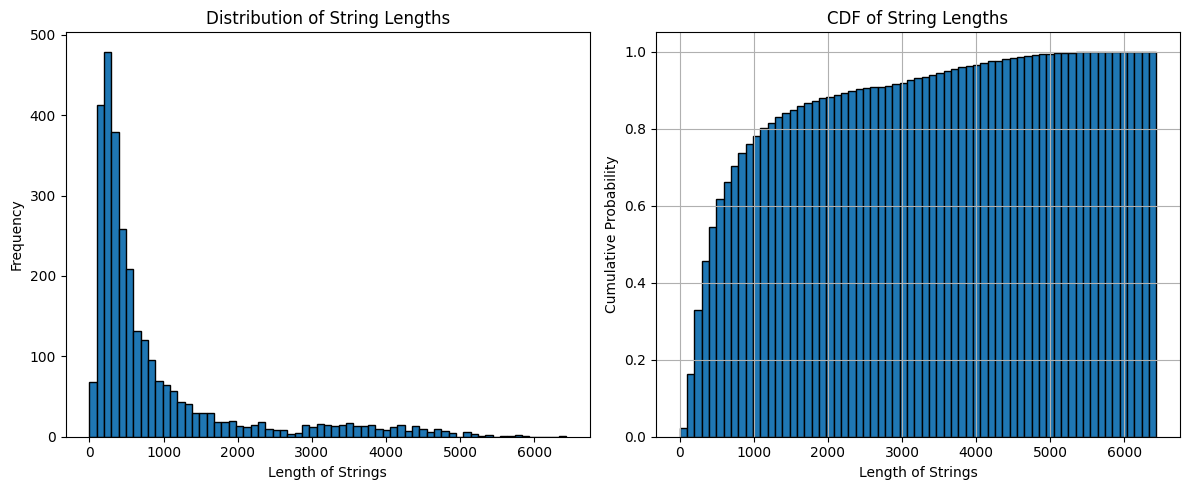

In [76]:
import matplotlib.pyplot as plt

# Calculate the lengths of each string
lengths = [len(s) for s in output]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram (distribution) on the first subplot
axes[0].hist(lengths, bins='auto', edgecolor='black')
axes[0].set_title("Distribution of String Lengths")
axes[0].set_xlabel("Length of Strings")
axes[0].set_ylabel("Frequency")

# Plot the CDF on the second subplot
axes[1].hist(lengths, bins='auto', cumulative=True, density=True, edgecolor='black')
axes[1].set_title("CDF of String Lengths")
axes[1].set_xlabel("Length of Strings")
axes[1].set_ylabel("Cumulative Probability")
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()



In [77]:
longest_string = max(output, key=len)
len(longest_string), longest_string

(6429,
 '1430 Conradus Pape (Papen) cler. Hildesem. dioc.: de perp. vicar. ad alt.\ns. Andree in eccl. Hildesem. (12 m.\narg.) vac. p. devol. vel p. resign.\nGerhardi Roberg vel Tilmanni Steyn\n18. nov. 77 S 761 12r – cler. Hildesem.: de par. eccl. in Honstat Magunt. dioc. (6 m. arg.) de iur. patron.\nlaic. vac. p. resign. Ludolphi Beghemon 13. ian. 78 S 765 164r –\nnullum benef. obtinens in 24. sue et.\nan. constit.: de 2 can. et preb. et 2\nbenef. ad coll. quorumcumque, Et\nacsi s. d. 1. ian. 72 conc. [cass.] 16.\nmai. 78 S 772 269rs – inter al. referens quod Ludolphus Rauen presb.\nHildesem. par. eccl. in op. Eltze et\nal. in op. Bodenborch Hildesem. dioc. absque disp. p. mensem detin.:\nde par. eccl. in Bodenborch Hildesem. dioc. (5 m. arg.) de iur. patron.\nlaic. vac. p. priv. d. Ludolphi 30.\nmai. 78 S 771 287vs – de perp. vicar.\neccl. s. Pauli Halberstad. de iur. patron. laic. (3 m. arg.) vac. p. o. in cur.\nJohannis Retteleff Johannis de Michaelis tit. s. Marcelli card. fam. 8

In [78]:
output[:10]

['',
 '1 Abeko Ewesma cler. Monast. dioc.\nde mil. gen. procreatus in univ. studii Lovanien. Leod. dioc. studens inter al. referens quod lis orta fuit inter\nThomam de Gelria cler. et Eberhardum abb. et conv. mon. s. Juliane in\nRothem o. s. Ben. Monast. dioc. sup.\nprepos. rurali in Usquard Monast.\ndioc. (de qua tunc vac. p. o. cuiusdam Juliani d. Thome sibi prov. fuit\nquamque dd. abb. et conv. d. monasterio uniri intendebant) coram Henrico Romer dec. eccl. Veteris Ecclesie s. Pauli Monast. (p. Hermannum\nSuderto dec. eccl. s. Martini Monast.\ndeput.) et deinde in cur. coram Johanne [de Ceretanis] ep. Nucerin.\naud. locumtenenti quodque deinde\nlite in cur. pendente de d. prepos.\nvac. p. o. d. Thome ipsi Abekoni\ntunc in 15. nunc in 17. sue et. an.\nconstit. p. Alexandrum [Numai] ep.\nForolivien. sed. ap. c. pot. legati de\nlatere nunt. sibi prov. fuit quodque\nipse Abeko d. prepos. p. 2 an. possedit quodque papa ad instantiam dd.\nabb. et conv. d. prepos. d. monasterio uniri manda

In [85]:
cleaned_header_without_number = re.sub(r"^\d+\s*", "", cleaned_header)
filtered_output = [re.sub(r"^\d+\s*", "", s) for s in output if len(s) < 0.2 * len(longest_string)]

In [86]:
len(filtered_output) / len(output)

0.8153846153846154

## Import Unknown Documents in Vector db

In [87]:
filtered_output[2380:2480]

['Gerstea\nOppidani op. Gerstee Aquileg. dioc.\nreferentes quod Turci ex regno Bosne sepe incursiones in illis partibus\ncommittunt et quod eapropter par.\neccl. d. op. extra limites murorum sitam intra muros d. op. transferre desiderant: de lic. transferendi et reedificandi d. par. eccl. et de indulg. 7\nan. 23. ian. 76 S 733 151rss.',
 'Gersten\nAbb. et conv. mon. Gersten. o. s.\nBen. Patav. dioc. cui p. longa temp.\npar. ecclesie in Gersten et in Gaflentz et diverse capel. fil. infra lim.\nPatav. dioc. unite fuerunt: de conf.\nconsuetudinem quod dd. par. eccl. et\ncapel. p. monach. gubernentur 25.\nsept. 71 S 672 37vs.',
 '[mon.] Sancte Gertrudis in Monte\nPriorissa et monial. mon. Sancte\nGertrudis in Monte o. s. Ben. Osnaburg. dioc. que cum adiutorio abba.\net monialium mon. in Herzburck o.\ns. Ben. Magunt. dioc. incluse et in\nmonastica disciplina institute sunt:\nde conc. quod privilegiis monasterio\nBussfelden. o. s. Ben. Magunt. dioc.\net unioni Bursfelden. eiusdem p.\nquascum

In [39]:
import chromadb
chroma_client = chromadb.PersistentClient(path="rg_vectordb")

In [40]:
collection = chroma_client.get_or_create_collection(name="rg_x_collection")

In [46]:
subset_size = 100
for i in tqdm(range(0, len(filtered_output), subset_size)):
    output_chunk = filtered_output[i: i + subset_size]
    collection.upsert(
        documents=output_chunk,
        ids=list(map(str, range(i, i + len(output_chunk))))
    )

  0%|          | 0/24 [00:00<?, ?it/s]

In [48]:
results = collection.query(
    query_texts=["2923 [mon.] Sancte Gertrudis in Monte\r\nPriorissa et monial. mon. Sancte\r\nGertrudis in Monte o. s. Ben. Osna\x02burg. dioc. que cum adiutorio abba.\r\net monialium mon. in Herzburck o.\r\ns. Ben. Magunt. dioc. incluse et in\r\nmonastica disciplina institute sunt:\r\nde conc. quod privilegiis monasterio\r\nBussfelden. o. s. Ben. Magunt. dioc.\r\net unioni Bursfelden. eiusdem p.\r\nquascumque litt. datis seu dandis\r\ngaudere possint 22. oct. 83 S 831\r\n3rs."], # Chroma will embed this for you
    n_results=10
)
results


{'ids': [['2382',
   '486',
   '495',
   '1110',
   '1197',
   '643',
   '1494',
   '1474',
   '1082',
   '652']],
 'distances': [[0.0,
   0.6015090942382812,
   0.6085736751556396,
   0.633771538734436,
   0.6628613471984863,
   0.6901247501373291,
   0.6934071779251099,
   0.6995242834091187,
   0.6999148726463318,
   0.7002724409103394]],
 'metadatas': [[None, None, None, None, None, None, None, None, None, None]],
 'embeddings': None,
 'documents': [['2923 [mon.] Sancte Gertrudis in Monte\r\nPriorissa et monial. mon. Sancte\r\nGertrudis in Monte o. s. Ben. Osna\x02burg. dioc. que cum adiutorio abba.\r\net monialium mon. in Herzburck o.\r\ns. Ben. Magunt. dioc. incluse et in\r\nmonastica disciplina institute sunt:\r\nde conc. quod privilegiis monasterio\r\nBussfelden. o. s. Ben. Magunt. dioc.\r\net unioni Bursfelden. eiusdem p.\r\nquascumque litt. datis seu dandis\r\ngaudere possint 22. oct. 83 S 831\r\n3rs.',
   '616 Astheim\r\nPrior et conv. dom. Pontis Marie in\r\nOstheim (Asthei

In [57]:
model = 'mistral-large-instruct'

## Get Data

### Create SQL query to get known documents with their role information


| uexternal_id_number | base_url | total_records_found | example_wiag |
|-----------------|--------------|--------------------|---------------|
|88| http://rg-online.dhi-roma.it/RPG/| 8| https://wiag-vocab.adw-goe.de/id/WIAG-Pers-CANON-46895-001|
|77| http://rg-online.dhi-roma.it/RG/| 595| https://wiag-vocab.adw-goe.de/id/WIAG-Pers-CANON-11396-001|
|75| https://resource.database.rag-online.org/| 1162| https://wiag-vocab.adw-goe.de/id/WIAG-Pers-CANON-12778-001|

https://wiag-vocab.adw-goe.de/id/WIAG-Pers-CANON-12778-001 => https://rag-online.org/datenbank/abfrage.p/0.m/embed.v/viewer.p|17|4|object|46-3986155

75 => https://api.metagrid.ch/beacon/rag


```sql
SELECT DISTINCT 
  i.id,
  CASE 
    WHEN t_id.epc IS NOT NULL THEN t_id.epc
    WHEN t_id.epc IS NULL AND t_id.can IS NOT NULL THEN t_id.can
    WHEN t_id.epc IS NULL AND t_id.can IS NULL AND t_id.dreg_can IS NOT NULL THEN t_id.dreg_can
  END AS id_public,
  uext.value AS gsn
FROM 
  item AS i
JOIN 
  url_external AS uext ON uext.item_id = i.id AND uext.authority_id = 77
JOIN 
  item_name_role AS inr ON inr.item_id_name = i.id
JOIN 
  (SELECT DISTINCT 
      ic.item_id AS item_id,
      ic_ii.id_public AS epc,
      ic_iii.id_public AS can,
      ic_iv.id_public AS dreg_can
   FROM 
      item_corpus AS ic
   LEFT JOIN 
      item_corpus AS ic_ii ON ic_ii.item_id = ic.item_id AND ic_ii.corpus_id = 'epc'
   LEFT JOIN 
      item_corpus AS ic_iii ON ic_iii.item_id = ic.item_id AND ic_iii.corpus_id = 'can'
   LEFT JOIN 
      item_corpus AS ic_iv ON ic_iv.item_id = ic.item_id AND ic_iv.corpus_id = 'dreg-can'
   WHERE 
      ic.corpus_id IN ('epc', 'can', 'dreg-can')
  ) AS t_id ON t_id.item_id = i.id
WHERE 
  i.is_online = 1;
```

```sql
SELECT * FROM 
  item AS i
JOIN url_external AS uext ON uext.item_id = i.id AND uext.authority_id = 77
JOIN item_name_role AS inr ON inr.item_id_name = i.id
WHERE i.is_online = 1;
```

In [3]:
# OPTIONAL: Alternatively read the access db https://stackoverflow.com/a/63578208

In [ ]:
wiag_id = 'WIAG-Pers-CANON-46895-001'
f'https://wiag-vocab.adw-goe.de/id/{wiag_id}?format=Json'

http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=10414109&docConstraints[rgvol]=4


http://rg-online.dhi-roma.it/RG/8/3448
http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=10803448&docConstraints[rgvol]=8

In [ ]:
http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=10803448&docConstraints[rgvol]=8


In [40]:
import re

def check_framecall(location):
    # translated from the code at http://rg-online.dhi-roma.it/RG/8/3448 
    # by inspecting the source and checking the network tab

    # Extract rgVol and id from location
    rgVol = re.search(r"\d+", location).group()
    id = re.search(r"\d+$", location).group()

    # Update id if it matches 'AM' pattern
    if re.search(r"AM\d+$", location):
        id = re.search(r"AM\d+$", location).group()

    # Adjust rgVol and rgVolReal based on RPG presence
    if re.search(r"RPG", location):
        rgVolReal = str(int(rgVol) + 9)
        rgVol = str(int(rgVol) + 9)
    else:
        rgVolReal = rgVol
        rgVol = f"0{rgVol}"

    # Pad id to have a length of 5 characters
    id = id.zfill(5)

    # Construct the frames dictionary with URLs
    retval = f"http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=1{rgVol}{id}&docConstraints[rgvol]={rgVolReal}"

    return retval

# Example usage:
location = "RG/8/3448"  # Example location string, replace with actual URL or input
url = check_framecall(location)
assert url == 'http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=10803448&docConstraints[rgvol]=8'

In [41]:
wiag_id = 'WIAG-Pers-CANON-11396-001'
wiag_url = f'https://wiag-vocab.adw-goe.de/id/{wiag_id}?format=Json'
response = requests.get(wiag_url, headers = {
    'Content-Type': 'application/json'
})
json_resp = response.json()
print(json.dumps(json_resp, indent=4))
print(json_resp)

del json_resp["persons"][0]["wiagId"]
del json_resp["persons"][0]["identifier"]
del json_resp["persons"][0]["offices"][1]["references"]
print(json_resp)

{
    "persons": [
        {
            "wiagId": "WIAG-Pers-CANON-11396-001",
            "givenname": "Johann",
            "prefix": "von",
            "familyname": "Raesfeld",
            "identifier": {
                "Personendatenbank der Germania Sacra": "http://personendatenbank.germania-sacra.de/index/gsn/043-02745-001",
                "Repertorium Germanicum Online": "http://rg-online.dhi-roma.it/RG/8/3448",
                "Factgrid": "https://database.factgrid.de/entity/Q721663"
            },
            "offices": [
                {
                    "title": "Dompropst",
                    "dateBegin": "1458",
                    "dateEnd": "1483",
                    "institution": "Domstift Osnabr\u00fcck",
                    "references": [
                        {
                            "citation": "Christian Hoffmann, Osnabr\u00fcck \u2013 Domstift St. Petrus, in: Nieders\u00e4chsisches Klosterbuch. Verzeichnis der Kl\u00f6ster, Stifte, Kommenden und

In [42]:
filename='item_20241107.csv'
df = pd.read_csv(f'data_files/{filename}', names=['row_id', 'wiag_id', 'rg_id'])
df['processed_rg_id'] = df['rg_id'].apply(check_framecall)
df

row_id                    wiag_id    rg_id  \
0     30458  WIAG-Pers-CANON-11396-001   8/3448   
1     32150  WIAG-Pers-CANON-13408-001  4/14109   
2     32149  WIAG-Pers-CANON-13409-001    6/582   
3     32149  WIAG-Pers-CANON-13409-001   6/3271   
4     32477  WIAG-Pers-CANON-13742-001    2/338   
..      ...                        ...      ...   
592   60744  WIAG-Pers-CANON-48848-001   2/8412   
593   60744  WIAG-Pers-CANON-48848-001  4/10625   
594   62294  WIAG-Pers-CANON-49361-001   6/4460   
595   52943  WIAG-Pers-CANON-49375-001   5/5265   
596   32066  WIAG-Pers-CANON-13312-001   2/4312   

                                       processed_rg_id  
0    http://rg-online.dhi-roma.it/denqrg/index.php?...  
1    http://rg-online.dhi-roma.it/denqrg/index.php?...  
2    http://rg-online.dhi-roma.it/denqrg/index.php?...  
3    http://rg-online.dhi-roma.it/denqrg/index.php?...  
4    http://rg-online.dhi-roma.it/denqrg/index.php?...  
..                                                 ...  
592  http://rg-online.dhi-roma.it/denqrg/index.php?...  
593  http://rg-online.dhi-roma.it/denqrg/index.php?...  
594  http://rg-online.dhi-roma.it/denqrg/index.php?...  
595  http://rg-online.dhi-roma.it/denqrg/index.php?...  
596  http://rg-online.dhi-roma.it/denqrg/index.php?...  

[597 rows x 4 columns]

In [43]:
from html.parser import HTMLParser

url = df["processed_rg_id"][0]
print(url)
response = requests.get(url, headers = {
    'Content-Type': 'application/json'
})
all_text = response.text

http://rg-online.dhi-roma.it/denqrg/index.php?view=doc_layout&docConstraints[byID]=yes&docConstraints[id]=10803448&docConstraints[rgvol]=8


In [44]:
from html.parser import HTMLParser
import requests

class TableTextExtractor(HTMLParser):
    def __init__(self):
        super().__init__()
        self.local_reset()
    
    def local_reset(self):
        self.reset()
        self.text = []
        self.in_first_table = False
        self.table_found = False
        self.marker_tag = "reg"

    def handle_starttag(self, tag, attrs):
        if tag == self.marker_tag and not self.table_found:
            # Start capturing text once the first <table> tag is found
            self.in_first_table = True
            self.table_found = True

    def handle_endtag(self, tag):
        if tag == self.marker_tag and self.in_first_table:
            # Stop capturing once the first table's closing tag is found
            self.in_first_table = False

    def handle_data(self, data):
        if self.in_first_table:
            # Collect data only if we are inside the first table
            self.text.append(data.strip().replace('  ', ' '))

    def get_text(self):
        # Join all collected text segments from within the table
        return ' '.join(self.text).strip()

parser = TableTextExtractor()
parser.feed(response.text)  # Feed the HTML content to the parser

visible_text = parser.get_text()

In [45]:
visible_text

"Johannes de Raesfelt Rasvel t , Rosvelt, Raszvelt de nob.  gen. Nicolai tit.  s. Petri ad vincula presb. card.  fam.   de prepos.  eccl.  Osnaburg.  10 m. arg.   vacat.  p.  prom. Nicolai de Crepanica Crapanica  sed. ap. prothon. ad eccl. Firman. , n. o.  can. et preb.  eccl.  s. Victoris  Xancten. Colon.  dioc.  4 m. arg.  quos possidet necnon iur. in pens.  ann. 150 fl. renen.  sup.  fruct.  prepos.  eccl. Aldensalen. Traiect.  dioc. quam n. possidet 21. oct. 1458  S 514 9vs ., L 539 181v-183v .   l. b.  nov. 1458  T 9 7v .  de nova prov. de prepos. ut supra, n. o. ut supra et al.  benef.  2 m. arg.   16. decb. 1458  S 516 52vs .   ex utr. de nob.  gen. : de incompat.  unac.  prepos.  Osnaburg.  20 m. arg.  , fiat de 2 par. eccl. ad 5 an.  19. decb. 1458  S 516 55vs ., L 546 143vss .   cler.  Monast.  dioc. : motu pr. de prepos. Veterisecclesie s. Pauli Monast.  10 ac de can. et preb.  eccl.  Monast.  4 m. arg.   vac.  p. o. Johannis Hake , n. o. statutis quib. cavetur quod nullus e

In [46]:
import pandas as pd
import asyncio
import aiohttp
import traceback

# Async function to fetch data for a row
async def fetch(session, value, is_url=False):
    """
    Fetch data for a row. 
    If `is_url` is True, the value is treated as a full URL. Otherwise, it is treated as an ID to construct a URL.
    """
    if not is_url:
        url = f'https://wiag-vocab.adw-goe.de/id/{value}?format=Json'  # Replace with your API endpoint
    else:
        url = value

    try:
        async with session.get(url) as response:
            if response.status == 200:
                if is_url:
                    parser = TableTextExtractor()
                    response_text = await response.text()
                    parser.feed(response_text)  # Feed the HTML content to the parser
                    return parser.get_text()
                else:
                    return await response.json()  # Parse the response as JSON
            else:
                return {'error': f"HTTP {response.status}"}
    except Exception as e:
        stack_trace = traceback.format_exc()
        return {'error': str(stack_trace)}

# Async function to gather all responses
async def fetch_all(dataframe, column, is_url=False):
    """
    Fetch data for all rows in the specified column.
    If `is_url` is True, the column contains full URLs. Otherwise, it contains IDs.
    """
    async with aiohttp.ClientSession() as session:
        tasks = [fetch(session, value, is_url) for value in dataframe[column]]
        return await asyncio.gather(*tasks)

async def fetch_errors(dataframe, column, json_column, is_url=False):
    """
    Fetch data for rows that have errors or missing values in the JSON column.
    If `is_url` is True, the column contains full URLs. Otherwise, it contains IDs.
    """
    async with aiohttp.ClientSession() as session:
        tasks = []
        indices = []
        for idx, row in dataframe.iterrows():
            # Check if the current row has an error or is not fetched
            if row[json_column] is None or isinstance(row[json_column], dict) and 'error' in row[json_column]:
                tasks.append(fetch(session, row[column], is_url))
                indices.append(idx)
        # Execute only the tasks for the error rows
        results = await asyncio.gather(*tasks)
        return indices, results

# Function to retry only error rows until none remain
async def update_error_rows_until_complete(dataframe, column, json_column, is_url=False):
    """
    Retry fetching data for error rows until all rows are successfully updated.
    If `is_url` is True, the column contains full URLs. Otherwise, it contains IDs.
    """
    while True:
        indices, results = await fetch_errors(dataframe, column, json_column, is_url)
        print(f"Number of rows to be updated: {len(indices)}")  # Print the number of rows being updated
        if not indices:  # If no more rows need updating, exit the loop
            break
        for idx, result in zip(indices, results):
            dataframe.at[idx, json_column] = result  # Update the row with the new result
    print("All rows are updated.")

In [47]:
id_column = 'wiag_id'
json_column = 'wiag_json'

# Run the async function and store results in a new column
print("Starting initial fetch...")
results = await fetch_all(df, id_column)
df[json_column] = results

print("Done with initial fetch, updating error rows now...")
await update_error_rows_until_complete(df, id_column, json_column)

df

Starting initial fetch...
Done with initial fetch, updating error rows now...
Number of rows to be updated: 104
Number of rows to be updated: 33
Number of rows to be updated: 0
All rows are updated.


row_id                    wiag_id    rg_id  \
0     30458  WIAG-Pers-CANON-11396-001   8/3448   
1     32150  WIAG-Pers-CANON-13408-001  4/14109   
2     32149  WIAG-Pers-CANON-13409-001    6/582   
3     32149  WIAG-Pers-CANON-13409-001   6/3271   
4     32477  WIAG-Pers-CANON-13742-001    2/338   
..      ...                        ...      ...   
592   60744  WIAG-Pers-CANON-48848-001   2/8412   
593   60744  WIAG-Pers-CANON-48848-001  4/10625   
594   62294  WIAG-Pers-CANON-49361-001   6/4460   
595   52943  WIAG-Pers-CANON-49375-001   5/5265   
596   32066  WIAG-Pers-CANON-13312-001   2/4312   

                                       processed_rg_id  \
0    http://rg-online.dhi-roma.it/denqrg/index.php?...   
1    http://rg-online.dhi-roma.it/denqrg/index.php?...   
2    http://rg-online.dhi-roma.it/denqrg/index.php?...   
3    http://rg-online.dhi-roma.it/denqrg/index.php?...   
4    http://rg-online.dhi-roma.it/denqrg/index.php?...   
..                                                 ...   
592  http://rg-online.dhi-roma.it/denqrg/index.php?...   
593  http://rg-online.dhi-roma.it/denqrg/index.php?...   
594  http://rg-online.dhi-roma.it/denqrg/index.php?...   
595  http://rg-online.dhi-roma.it/denqrg/index.php?...   
596  http://rg-online.dhi-roma.it/denqrg/index.php?...   

                                             wiag_json  
0    {'persons': [{'wiagId': 'WIAG-Pers-CANON-11396...  
1    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13408...  
2    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13409...  
3    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13409...  
4    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13742...  
..                                                 ...  
592  {'persons': [{'wiagId': 'WIAG-Pers-CANON-48848...  
593  {'persons': [{'wiagId': 'WIAG-Pers-CANON-48848...  
594  {'persons': [{'wiagId': 'WIAG-Pers-CANON-49361...  
595  {'persons': [{'wiagId': 'WIAG-Pers-CANON-49375...  
596  {'persons': [{'wiagId': 'WIAG-Pers-CANON-13312...  

[597 rows x 5 columns]

In [48]:
url_column = 'processed_rg_id'
json_column = 'rg_json'

# Run the async function and store results in a new column
print("Starting initial fetch with URLs...")
results = await fetch_all(df, url_column, is_url=True)
df[json_column] = results

print("Updating error rows using URLs...")
await update_error_rows_until_complete(df, url_column, json_column, is_url=True)

df

Starting initial fetch with URLs...
Updating error rows using URLs...
Number of rows to be updated: 0
All rows are updated.


row_id                    wiag_id    rg_id  \
0     30458  WIAG-Pers-CANON-11396-001   8/3448   
1     32150  WIAG-Pers-CANON-13408-001  4/14109   
2     32149  WIAG-Pers-CANON-13409-001    6/582   
3     32149  WIAG-Pers-CANON-13409-001   6/3271   
4     32477  WIAG-Pers-CANON-13742-001    2/338   
..      ...                        ...      ...   
592   60744  WIAG-Pers-CANON-48848-001   2/8412   
593   60744  WIAG-Pers-CANON-48848-001  4/10625   
594   62294  WIAG-Pers-CANON-49361-001   6/4460   
595   52943  WIAG-Pers-CANON-49375-001   5/5265   
596   32066  WIAG-Pers-CANON-13312-001   2/4312   

                                       processed_rg_id  \
0    http://rg-online.dhi-roma.it/denqrg/index.php?...   
1    http://rg-online.dhi-roma.it/denqrg/index.php?...   
2    http://rg-online.dhi-roma.it/denqrg/index.php?...   
3    http://rg-online.dhi-roma.it/denqrg/index.php?...   
4    http://rg-online.dhi-roma.it/denqrg/index.php?...   
..                                                 ...   
592  http://rg-online.dhi-roma.it/denqrg/index.php?...   
593  http://rg-online.dhi-roma.it/denqrg/index.php?...   
594  http://rg-online.dhi-roma.it/denqrg/index.php?...   
595  http://rg-online.dhi-roma.it/denqrg/index.php?...   
596  http://rg-online.dhi-roma.it/denqrg/index.php?...   

                                             wiag_json  \
0    {'persons': [{'wiagId': 'WIAG-Pers-CANON-11396...   
1    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13408...   
2    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13409...   
3    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13409...   
4    {'persons': [{'wiagId': 'WIAG-Pers-CANON-13742...   
..                                                 ...   
592  {'persons': [{'wiagId': 'WIAG-Pers-CANON-48848...   
593  {'persons': [{'wiagId': 'WIAG-Pers-CANON-48848...   
594  {'persons': [{'wiagId': 'WIAG-Pers-CANON-49361...   
595  {'persons': [{'wiagId': 'WIAG-Pers-CANON-49375...   
596  {'persons': [{'wiagId': 'WIAG-Pers-CANON-13312...   

                                               rg_json  
0    Johannes de Raesfelt Rasvel t , Rosvelt, Raszv...  
1    Tilmannus de Indagine dec.  Trever.  ex utr. d...  
2    Burckardus Furderer de Vayhingen cler.  Spiren...  
3    Johannes Nagel presb.  Spiren.  dioc.   de pro...  
4    Albertus de Eldingen de mil. gen, can.  Hildes...  
..                                                 ...  
592  Martinus de Lichtenstein de mil.  gen.  can.  ...  
593  Martinus de Lichtenstein Liechtenstein de nob....  
594  Nicolaus de Helmstat   l. b.  mai. 1450  T 7 7...  
595  Johannes Nix de Hoheneck al.  d. Entzbergher S...  
596  Johannes Hoffard de mil.  gen.  can.  Magunt. ...  

[597 rows x 6 columns]

In [49]:
print(df['rg_json'][595])

Johannes Nix de Hoheneck al.  d. Entzbergher Sitzbergher, Gutzbergher  ex utr. de mil.  gen.   de par. eccl. in Stetten Wormat.  dioc.  10 m. arg.   vacat.  p.  ingr.  mon. in Mulbron o. Cist.  p. Conradum Monnichinghen et de disp.  sup.  def.  et.  23 an.  ; n.o.  can. et preb.  eccl.  s. Germani e.m.  Spiren.  10 m. arg.  9. apr. 34 S 295 138vs , de ref.  c.  express. quod in can.  eccl.  Magunt.  auct.  ordin. receptus est 19. apr. 1434  S 295 211v .  de nova prov. de can. et preb.  eccl.  Magunt.  16 m. arg.   vac.  p.o. Rabani de Helmstat; n.o.  can. et preb.  eccl.  s. Germani e.m.  Spiren.  14 m. arg.   3. iul. 1436  S 326 253v .  qui can. et preb.  eccl.  Spiren.  14 m. arg.  via perm.  c. Erkingero Haffwart Hoffwart pro can. et preb.  eccl.  s. Germani e.m.  Spiren.  assec. est: de nova prov. quia d. E. fam.  card.  s. Crucis fuit; n.o. lite in concil.  Basil.  sup.  can. et preb.  eccl.  Magunt.  15 m. arg. , quos possidet <et par. eccl.  s. Leonis [in .] Spiren.  dioc.  14 m

In [50]:
df.to_csv('known_db.csv', sep=';')

## Create Known documents VectorDB

In [51]:
import chromadb
chroma_client = chromadb.PersistentClient(path="rg_vectordb")

In [52]:
known_collection = chroma_client.get_or_create_collection(name="known_rg_collection")

In [62]:
df[df['wiag_id'] == 'WIAG-Pers-CANON-43105-001']

row_id                    wiag_id    rg_id  \
157   55301  WIAG-Pers-CANON-43105-001   4/7899   
158   55301  WIAG-Pers-CANON-43105-001  4/13905   
159   55301  WIAG-Pers-CANON-43105-001   5/4296   
160   55301  WIAG-Pers-CANON-43105-001   4/3962   
161   55301  WIAG-Pers-CANON-43105-001   4/4111   
162   55301  WIAG-Pers-CANON-43105-001   4/7007   
163   55301  WIAG-Pers-CANON-43105-001   4/8979   
164   55301  WIAG-Pers-CANON-43105-001   4/8986   
165   55301  WIAG-Pers-CANON-43105-001  4/11317   
166   55301  WIAG-Pers-CANON-43105-001   5/1781   
167   55301  WIAG-Pers-CANON-43105-001   5/3463   
168   55301  WIAG-Pers-CANON-43105-001   5/5555   
169   55301  WIAG-Pers-CANON-43105-001   5/6153   
170   55301  WIAG-Pers-CANON-43105-001   4/1028   

                                       processed_rg_id  \
157  http://rg-online.dhi-roma.it/denqrg/index.php?...   
158  http://rg-online.dhi-roma.it/denqrg/index.php?...   
159  http://rg-online.dhi-roma.it/denqrg/index.php?...   
160  http://rg-online.dhi-roma.it/denqrg/index.php?...   
161  http://rg-online.dhi-roma.it/denqrg/index.php?...   
162  http://rg-online.dhi-roma.it/denqrg/index.php?...   
163  http://rg-online.dhi-roma.it/denqrg/index.php?...   
164  http://rg-online.dhi-roma.it/denqrg/index.php?...   
165  http://rg-online.dhi-roma.it/denqrg/index.php?...   
166  http://rg-online.dhi-roma.it/denqrg/index.php?...   
167  http://rg-online.dhi-roma.it/denqrg/index.php?...   
168  http://rg-online.dhi-roma.it/denqrg/index.php?...   
169  http://rg-online.dhi-roma.it/denqrg/index.php?...   
170  http://rg-online.dhi-roma.it/denqrg/index.php?...   

                                             wiag_json  \
157  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
158  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
159  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
160  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
161  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
162  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
163  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
164  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
165  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
166  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
167  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
168  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
169  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   
170  {'persons': [{'wiagId': 'WIAG-Pers-CANON-43105...   

                                               rg_json  
157  Johannes Houesche Honesche  vic. in eccl.  s. ...  
158  Tidericus [.] <Swertfegher de Hamelspring> cle...  
159  Johannes Christiani de Alvelde  can. capitul. ...  
160  Hartmannus Swertfegher de Hamelspringe cler.  ...  
161  Hinricus de Adenstede  de decan.  eccl.  s. cr...  
162  Johannes Christiani de Aluelde  not.  subdiac....  
163  Johannes Rodenberg Rodenbergh, Rodenborg de Ha...  
164  Johannes Rodewolt cler.  Minden.   de prov. si...  
165  Nicolaus Volrat Volrad, Wlrat  cler.  abbrev. ...  
166  Verden   eccl. V., cuius mensa episc. propter ...  
167  Hermannus Wittebecker Reittebecker  cler.  Pad...  
168  Johannes Saffan cler.  Verden.  dioc.   de com...  
169  Lambertus Spunder cler.  Minden.  dioc.   de s...  
170  Bertoldus Blod presb.  Magunt.   de par. eccl....

In [68]:
df[df['wiag_id'] == 'WIAG-Pers-CANON-11396-001']

row_id                    wiag_id   rg_id  \
0   30458  WIAG-Pers-CANON-11396-001  8/3448   

                                     processed_rg_id  \
0  http://rg-online.dhi-roma.it/denqrg/index.php?...   

                                           wiag_json  \
0  {'persons': [{'wiagId': 'WIAG-Pers-CANON-11396...   

                                             rg_json  
0  Johannes de Raesfelt Rasvel t , Rosvelt, Raszv...

In [171]:
import json

def flatten_person_data(json_data):
    """
    Flattens the first person's data into the specified format.
    Removes 'identifier', 'references', and 'wiagId'.
    Converts the 'offices' list to a JSON string.
    
    Args:
        json_data (dict): JSON data containing a list of persons.
        
    Returns:
        dict: Flattened data for the first person.
    """
    # Extract the first person
    persons = json_data.get("persons", [])
    if not persons:
        return None  # Return None if there are no persons

    first_person = persons[0]
    # Extract required fields
    flattened_person = {
        key: value for key, value in first_person.items() if key not in ["identifier", "wiagId", "biographicalNotes"]
    }
    
    # Convert the offices list to a JSON string
    if "offices" in flattened_person:
        offices_list = [
            {key: value for key, value in office.items() if key != "references"}
            for office in flattened_person["offices"]
        ]
        flattened_person["offices"] = json.dumps(offices_list)  # Convert to JSON string

    return flattened_person


def reconstruct_original_document(flattened_data):
    """
    Reconstructs the original document structure from the flattened data.
    Converts the 'offices' JSON string back to a list.
    
    Args:
        flattened_data (dict): Flattened data for a person.

    Returns:
        dict: Reconstructed document.
    """
    if not flattened_data:
        return {"persons": []}  # Return empty structure if no data

    # Convert the 'offices' JSON string back to a list
    reconstructed_person = flattened_data.copy()
    if "offices" in reconstructed_person:
        reconstructed_person["offices"] = json.loads(reconstructed_person["offices"])

    return {"persons": [reconstructed_person]}


# Example usage:
data = {
    "persons": [
        {
            "wiagId": "WIAG-Pers-CANON-11396-001",
            "givenname": "Johann",
            "prefix": "von",
            "familyname": "Raesfeld",
            "identifier": {
                "Personendatenbank der Germania Sacra": "http://personendatenbank.germania-sacra.de/index/gsn/043-02745-001",
                "Repertorium Germanicum Online": "http://rg-online.dhi-roma.it/RG/8/3448",
                "Factgrid": "https://database.factgrid.de/entity/Q721663"
            },
            "offices": [
                {
                    "title": "Dompropst",
                    "diocese": "Bistum Osnabrück",
                    "dateBegin": "1458",
                    "dateEnd": "1483",
                    "institution": "Domstift Osnabrück"
                },
                {
                    "title": "Dompropst",
                    "dateBegin": "1458",
                    "dateEnd": "1483",
                    "institution": "Domstift Osnabrück",
                    "references": [
                        {
                            "citation": "Christian Hoffmann, Osnabrück – Domstift St. Petrus",
                            "authorOrEditor": "Hoffmann, Christian",
                            "shortTitle": "Niedersächsisches Klosterbuch, Domstift Osnabrück"
                        }
                    ]
                }
            ]
        }
    ]
}

flattened = flatten_person_data(data)
print("Flattened Data:", json.dumps(flattened, indent=4))

reconstructed = reconstruct_original_document(flattened)
print("\nReconstructed Document:", json.dumps(reconstructed, indent=4))


Flattened Data: {
    "givenname": "Johann",
    "prefix": "von",
    "familyname": "Raesfeld",
    "offices": "[{\"title\": \"Dompropst\", \"diocese\": \"Bistum Osnabr\\u00fcck\", \"dateBegin\": \"1458\", \"dateEnd\": \"1483\", \"institution\": \"Domstift Osnabr\\u00fcck\"}, {\"title\": \"Dompropst\", \"dateBegin\": \"1458\", \"dateEnd\": \"1483\", \"institution\": \"Domstift Osnabr\\u00fcck\"}]"
}

Reconstructed Document: {
    "persons": [
        {
            "givenname": "Johann",
            "prefix": "von",
            "familyname": "Raesfeld",
            "offices": [
                {
                    "title": "Dompropst",
                    "diocese": "Bistum Osnabr\u00fcck",
                    "dateBegin": "1458",
                    "dateEnd": "1483",
                    "institution": "Domstift Osnabr\u00fcck"
                },
                {
                    "title": "Dompropst",
                    "dateBegin": "1458",
                    "dateEnd": "1483",


In [172]:
subset_size = 100

for i in tqdm(range(0, len(df), subset_size)):
    # Extract chunked data for each column
    output_chunk = df['rg_json'][i: i + subset_size].tolist()
    metadata_chunk = df['wiag_json'][i: i + subset_size].tolist()
    # print(len(metadata_chunk))
    # for mc in metadata_chunk:
    #     if type(mc) != dict:
    #         print(type(mc))
    metadata_chunk = [flatten_person_data(item) for item in metadata_chunk]
    ids_chunk_wiag = df['wiag_id'][i: i + subset_size].astype(str).tolist()
    ids_chunk_rg = df['rg_id'][i: i + subset_size].astype(str).tolist()
    ids_chunk = [f"{id_wiag} {id_rg}" for id_wiag, id_rg in zip(ids_chunk_wiag, ids_chunk_rg)]
    
    # Insert into collection
    known_collection.upsert(
        documents=output_chunk,
        metadatas=metadata_chunk,
        ids=ids_chunk
    )


  0%|          | 0/6 [00:00<?, ?it/s]

## Create query builder which takes in multiple known documents and a single unknown document

In [173]:
import dotenv
import os
from openai import OpenAI
dotenv.load_dotenv()

True

In [174]:
api_key = os.environ.get("API_KEY")
base_url = os.environ.get("ENDPOINT")
client = OpenAI(
    api_key = api_key,
    base_url = base_url
)
response = requests.get(f'{base_url}/models', headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json'
})
models = [model["id"] for model in response.json()["data"]]
print(models)

['meta-llama-3.1-8b-instruct', 'internvl2-8b', 'meta-llama-3.1-70b-instruct', 'llama-3.1-nemotron-70b-instruct', 'llama-3.1-sauerkrautlm-70b-instruct', 'mistral-large-instruct', 'qwen2.5-72b-instruct', 'codestral-22b']


In [175]:
model = 'meta-llama-3.1-70b-instruct'

In [211]:
def information_extractor(unknown_doc, collection, system_prompt=''):
    

    query = build_query(unknown_doc, collection)

    if not system_prompt:
        # TODO: only environment, shorter system prompts
        system_prompt = """You are a Latin text processor. Look at the examples and solve the final question in the json format provided. Only respond with the answer."""
    chat_completion = client.chat.completions.create(
        messages=[{
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": query
        }],
        model=model,
        # try removing the line below for a more open format
        response_format={ "type": "json_object" },
        temperature=0,
        extra_headers = {
            "inference-service": model,
        }
    )
    return chat_completion.choices[0].message.content.strip()

In [220]:
def build_query(lemma: str, collection, n_examples=4):
    # todo: add more statement in the query in the final lemma
    results = collection.query(
        query_texts=[lemma],
        n_results=n_examples
    )
    qa_docs = ""
    empty_json = {
        'persons': [
            {
                'givenname': '', 'prefix': '', 'familyname': '', 
                'offices': [
                ]
            }
        ]
    }
    documents = results["documents"][0]
    # print(len(documents), len(documents[0]), documents)
    metadatas = results["metadatas"][0]
    # print(len(metadatas), metadatas)
    jsons = [reconstruct_original_document(item) for item in metadatas]
    empty_json = json.dumps(empty_json)
    for doc, json_s in zip(documents, jsons):
        qa_docs += f"Q: {doc}\nA: {json_s}\n"
    return f"""
```
{qa_docs}
Q: {lemma}
A: {empty_json}
```"""

In [221]:
output[500]

'500 Antonius Pottage can. eccl. s. Salvatoris Traiect. cui de par. eccl. de\nBrienne partium Cleven. Traiect. dioc. vac. p. o. ultimi possessoris p.\nprep. et archid. eccl. Traiect. prov.\nfuit: de nova prov. de eadem (7 m.\narg.) 21. nov. 72 S 684 204r\n.'

In [222]:
test_lemma = re.sub(r"^\d+\s*", "", output[500])
test_lemma

'Antonius Pottage can. eccl. s. Salvatoris Traiect. cui de par. eccl. de\nBrienne partium Cleven. Traiect. dioc. vac. p. o. ultimi possessoris p.\nprep. et archid. eccl. Traiect. prov.\nfuit: de nova prov. de eadem (7 m.\narg.) 21. nov. 72 S 684 204r\n.'

In [223]:
unkown_df = pd.DataFrame([re.sub(r"^\d+\s*", "", regist) for regist in output], columns=['regist'])
unkown_df

regist
0                                                      
1     Abeko Ewesma cler. Monast. dioc.\nde mil. gen....
2     Abelinus de Mussen cler. Monast.\ndioc.: motu ...
3     Abraham de Lowemberch qui litig.\ncoram Johann...
4     Abraham de Ostrow perp. vic. in\neccl. Plocen....
...                                                 ...
2920  Gerstea\nOppidani op. Gerstee Aquileg. dioc.\n...
2921  Gersten\nAbb. et conv. mon. Gersten. o. s.\nBe...
2922  [mon.] Sancte Gertrudis in Monte\nPriorissa et...
2923  Gervasius Sturmer in decr. licent.:\nde nova p...
2924  Gerwinus Haner de Susaco cler.\nColon. dioc. i...

[2925 rows x 1 columns]

In [224]:
information_extractor(test_lemma, known_collection)

'{ \n \t"persons"\t: \t[ \n \t\t{ \n \t\t\t"familyname"\t: \t"Pottage"\t, \n \t\t\t"givenname"\t: \t"Antonius"\t, \n \t\t\t"offices"\t: \t[ \n \t\t\t\t{ \n \t\t\t\t\t"title"\t: \t"Kanoniker"\t, \n \t\t\t\t\t"institution"\t: \t"St. Salvator, Utrecht" \n \t\t\t\t} \n \t\t\t] \n \t\t} \n \t] \n}'

In [225]:
tqdm.pandas(desc="Processing rows")  # Add a description to the progress bar

In [226]:
nrows = 20
tqdm.pandas(desc=f"Processing first {nrows} rows")  # Add description to the progress bar
unkown_df.loc[:nrows, 'extracted_info'] = unkown_df.loc[:nrows, 'regist'].progress_apply(
    lambda x: information_extractor(x, known_collection)
)

# Display the resulting DataFrame
unkown_df.head(nrows)

Processing first 20 rows:   0%|          | 0/21 [00:00<?, ?it/s]

InternalServerError: Error code: 500

In [232]:
print(unkown_df['regist'][1])

Abeko Ewesma cler. Monast. dioc.
de mil. gen. procreatus in univ. studii Lovanien. Leod. dioc. studens inter al. referens quod lis orta fuit inter
Thomam de Gelria cler. et Eberhardum abb. et conv. mon. s. Juliane in
Rothem o. s. Ben. Monast. dioc. sup.
prepos. rurali in Usquard Monast.
dioc. (de qua tunc vac. p. o. cuiusdam Juliani d. Thome sibi prov. fuit
quamque dd. abb. et conv. d. monasterio uniri intendebant) coram Henrico Romer dec. eccl. Veteris Ecclesie s. Pauli Monast. (p. Hermannum
Suderto dec. eccl. s. Martini Monast.
deput.) et deinde in cur. coram Johanne [de Ceretanis] ep. Nucerin.
aud. locumtenenti quodque deinde
lite in cur. pendente de d. prepos.
vac. p. o. d. Thome ipsi Abekoni
tunc in 15. nunc in 17. sue et. an.
constit. p. Alexandrum [Numai] ep.
Forolivien. sed. ap. c. pot. legati de
latere nunt. sibi prov. fuit quodque
ipse Abeko d. prepos. p. 2 an. possedit quodque papa ad instantiam dd.
abb. et conv. d. prepos. d. monasterio uniri mandavit quodque d. unio
canoni

In [230]:
print(information_extractor(unkown_df['regist'][1], known_collection))

{ 
 	"persons"	: 	[ 
 		{ 
 			"familyname"	: 	"Ewesma"	, 
 			"givenname"	: 	"Abeko"	, 
 			"offices"	: 	[ 
 				{ 
 					"title"	: 	"Propst"	, 
 					"institution"	: 	"Propstei Usquard"	, 
 					"dateBegin"	: 	"vor 1477"	, 
 					"dateEnd"	: 	"vor 1477" 
 				} 
 			] 
 		} 
 	] 
}


In [210]:
tqdm.pandas(desc="Processing first 100 rows")  # Add description to the progress bar
unkown_df.loc[:99, 'extracted_info'] = unkown_df.loc[:99, 'regist'].progress_apply(
    lambda x: information_extractor(x, known_collection)
)

# Display the resulting DataFrame
unkown_df.head(100)

Processing first 100 rows:   0%|          | 0/100 [00:00<?, ?it/s]

regist  \
0                                                       
1   Abeko Ewesma cler. Monast. dioc.\nde mil. gen....   
2   Abelinus de Mussen cler. Monast.\ndioc.: motu ...   
3   Abraham de Lowemberch qui litig.\ncoram Johann...   
4   Abraham de Ostrow perp. vic. in\neccl. Plocen....   
..                                                ...   
95  Adrianus Guidonis de Recka actor\nqui litig. c...   
96  Arego [= Aesgo] Petri: prov. de\nmon. Traiect....   
97  Agger s. Martini\nDec. et capit. colleg. eccl....   
98  Nesa [= Agnes] relicta quond. Johannis Crulman...   
99  Nisa (Resa) Dringenberchs (Drungenberchs) et K...   

                                       extracted_info  
0             Please provide the question to process.  
1   {'dateOfrom. , 1480 m. 5. , n. , prov. , de ca...  
2   {"persons": [{"givenname": "Abelinus", "prefix...  
3   {"persons": [{"familyNameVariant": "Hoens, Hoe...  
4   {"persons": [{"dateOfDeath": "", "familyNameVa...  
..                                                ...  
95  {"persons": [{"familyname": "Guidonis", "given...  
96  {'persons': [{'givenname': 'Arego', 'prefix': ...  
97  {"persons": [{"givenname": "", "prefix": "", "...  
98                         {'persons \nA: {'persons':  
99                                                 {'  

[100 rows x 2 columns]

In [207]:
from joblib import Parallel, delayed

In [209]:
# BROKEN, run cell below
def parallel_apply(df_column, func, known_collection, n_jobs=4):
    """
    Parallelizes the application of a function to a pandas DataFrame column.
    
    Args:
        df_column (pd.Series): Column to process.
        func (function): Function to apply.
        known_collection: Additional arguments to pass to the function.
        n_jobs (int): Number of parallel jobs. Default is -1 (use all processors).
    
    Returns:
        pd.Series: Processed column.
    """
    # Use tqdm for progress tracking
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(func)(x, known_collection) for x in tqdm(df_column, desc="Processing in parallel")
    )
    return pd.Series(results, index=df_column.index)

# Apply the function in parallel
unkown_df['extracted_info'] = parallel_apply(unkown_df['regist'], information_extractor, known_collection)

Processing in parallel:   0%|          | 0/2925 [00:00<?, ?it/s]

PicklingError: Could not pickle the task to send it to the workers.

In [60]:
system_prompt = """You are a Latin text processor. Look at the examples and solve the final question in the json format provided. Only respond with the answer."""
empty_json = {
    'persons': [
        {
            'givenname': '', 'prefix': '', 'familyname': '', 
            'offices': [
            ]
        }
    ]
}
empty_json = json.dumps(empty_json)
chat_completion = client.chat.completions.create(
    messages=[{
        "role": "system",
        "content": system_prompt
    },
    {
        "role": "user",
        "content": f"Q: {test_lemma}\nA: {empty_json}"
    }],
    model=model,
    extra_headers = {
        "inference-service": model,
    }
)
chat_completion.choices[0].message.content.strip()

'{"persons": [{"givenname": "Antonius", "prefix": "", "familyname": "Pottage", "offices": ["canonicus ecclesiae Sancti Salvatoris Traiecti", "pastor ecclesiae de Brienne", "archidiaconus ecclesiae Traiecti"]}]}'

# Semantic Chunking Attempt (Not used)

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

In [ ]:
from chromadb.utils import embedding_functions
default_ef = embedding_functions.DefaultEmbeddingFunction()

In [ ]:
val = default_ef("foo")
val

[[0.0503581166267395,
  0.06264623999595642,
  -0.061827365309000015,
  0.03152845799922943,
  0.03411198779940605,
  0.04731567203998566,
  0.06201803311705589,
  0.059644874185323715,
  0.021589204668998718,
  0.006887160241603851,
  0.05046543851494789,
  -0.09534928947687149,
  -0.04039912670850754,
  0.019933508709073067,
  -0.0214021485298872,
  -0.020986570045351982,
  -0.07829968631267548,
  -0.03933179751038551,
  -0.08387243002653122,
  0.0033294064924120903,
  -0.04660399258136749,
  0.005695238243788481,
  0.0009875784162431955,
  0.018057916313409805,
  -0.059670720249414444,
  0.023389611393213272,
  -0.08691268414258957,
  0.03609900176525116,
  -0.08338861912488937,
  -0.10067611187696457,
  0.0008361744694411755,
  0.1192990392446518,
  0.06871477514505386,
  0.015917077660560608,
  -0.05228118225932121,
  -0.017528345808386803,
  0.012803016230463982,
  -0.013966410420835018,
  0.04338102415204048,
  0.0045759351924061775,
  -0.1090155690908432,
  -0.07069327682256699

In [ ]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(data[0].split('\r\n'))]
sentences[:3]

[{'sentence': '1 Abeko Ewesma cler. Monast. dioc.', 'index': 0},
 {'sentence': 'de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter',
  'index': 1},
 {'sentence': 'Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in',
  'index': 2}]

In [ ]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [ ]:
sentences[:3]

[{'sentence': '1 Abeko Ewesma cler. Monast. dioc.',
  'index': 0,
  'combined_sentence': '1 Abeko Ewesma cler. Monast. dioc. de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter'},
 {'sentence': 'de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter',
  'index': 1,
  'combined_sentence': '1 Abeko Ewesma cler. Monast. dioc. de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in'},
 {'sentence': 'Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in',
  'index': 2,
  'combined_sentence': 'de mil. gen. procreatus in univ. stu\x02dii Lovanien. Leod. dioc. studens in\x02ter al. referens quod lis orta fuit inter Thomam de Gelria cler. et Eberhar\x02dum abb. et conv. mon. s. Juliane in Rothem o. s. B

In [ ]:
embeddings = default_ef([x['combined_sentence'] for x in sentences])

In [ ]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [ ]:
sentence

{'sentence': 'prep. eccl. Gneznen. cancellarii reg\x02ni Polonie et eius nepotes (ex soro-',
 'index': 90,
 'combined_sentence': 'Dambrova dilecti Urielis de Gorka prep. eccl. Gneznen. cancellarii reg\x02ni Polonie et eius nepotes (ex soro-',
 'combined_sentence_embedding': [-0.05574823170900345,
  0.15960291028022766,
  -0.05336272716522217,
  -0.04253670945763588,
  -0.15593725442886353,
  0.017487119883298874,
  0.007487216033041477,
  0.03258059173822403,
  0.044702839106321335,
  0.04338592290878296,
  0.08403133600950241,
  -0.04498789459466934,
  -0.026931701228022575,
  -0.058074261993169785,
  -0.09262774139642715,
  -0.027710778638720512,
  -0.0756414532661438,
  0.08396363258361816,
  -0.03865562751889229,
  -0.002656476804986596,
  0.009786156937479973,
  -0.043534111231565475,
  0.017506178468465805,
  0.043101780116558075,
  -0.06574638932943344,
  0.009346836246550083,
  0.025948425754904747,
  -0.029088910669088364,
  -0.0007481059874407947,
  -0.01519983634352684,
  0.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [ ]:
distances, sentences = calculate_cosine_distances(sentences)

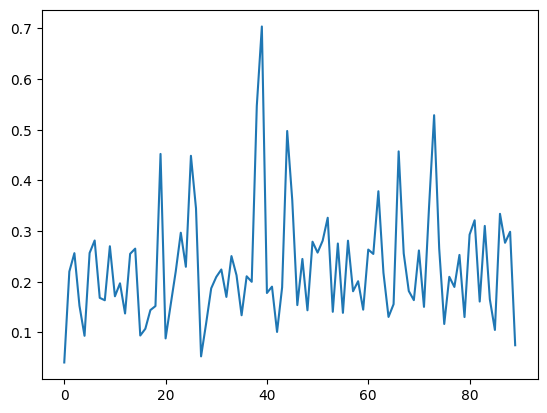

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances);

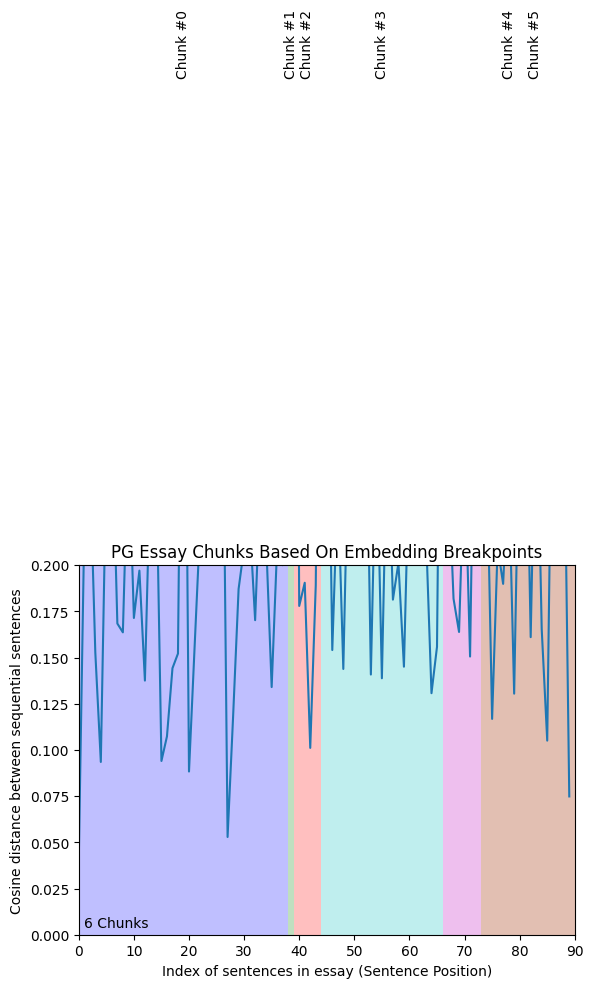

In [ ]:
import numpy as np

plt.plot(distances);

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
             y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
             s=f"Chunk #{i}", horizontalalignment='center',
             rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                 y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                 s=f"Chunk #{i+1}",
                 rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

In [ ]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [ ]:
for i, chunk in enumerate(chunks):
    buffer = 2000
    
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
1 Abeko Ewesma cler. Monast. dioc. de mil. gen. procreatus in univ. studii Lovanien. Leod. dioc. studens inter al. referens quod lis orta fuit inter Thomam de Gelria cler. et Eberhardum abb. et conv. mon. s. Juliane in Rothem o. s. Ben. Monast. dioc. sup. prepos. rurali in Usquard Monast. dioc. (de qua tunc vac. p. o. cuiusdam Juliani d. Thome sibi prov. fuit quamque dd. abb. et conv. d. monasterio uniri intendebant) coram Henrico Romer dec. eccl. Veteris Ecclesie s. Pauli Monast. (p. Hermannum Suderto dec. eccl. s. Martini Monast. deput.) et deinde in cur. coram Johanne [de Ceretanis] ep. Nucerin. aud. locumtenenti quodque deinde lite in cur. pendente de d. prepos. vac. p. o. d. Thome ipsi Abekoni tunc in 15. nunc in 17. sue et. an. constit. p. Alexandrum [Numai] ep. Forolivien. sed. ap. c. pot. legati de latere nunt. sibi prov. fuit quodque ipse Abeko d. prepos. p. 2 an. possedit quodque papa ad instantiam dd. abb. et conv. d. prepos. d. monasterio uniri mandavit q